$$
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\brac}[1]{\left\{#1\right\}}
\newcommand{\brak}[1]{\left[#1\right]}
\newcommand{\abs}[1]{\left|#1\right|}
\newcommand{\E}[1]{\mathbb{E}\left[#1\right]}
\newcommand{\pr}[1]{\Pr\paren{#1}}
\newcommand{\hr}{\hat{r}}
\newcommand{\ror}{r_{1 \cup 2}}
\newcommand{\rand}{r_{1 \cap 2}}
\newcommand{\hror}{\hr_{1 \cup 2}}
\newcommand{\Ror}{R_{1 \cup 2}}
\newcommand{\Rand}{R_{1 \cap 2}}
\newcommand{\heta}{\hat{\eta}}
\newcommand{\veta}{\bm{\eta}}
\newcommand{\hveta}{\hat{\veta}}
\newcommand{\halpha}{\hat{\alpha}}
$$


# 4章 連続最適化で広告予算を配分する

## ビジネス課題：広告予算配分の最適化

## ステップ1：ビジネス課題を数理最適化問題として定式化する

## ステップ2：数理モデル構築し、未知のパラメータをデータから推定する

In [1]:
import json  # ファイル読み込み
from typing import Self  # 型ヒント

import matplotlib.pyplot as plt  # 可視化
import numpy as np  # データ処理
import polars as pl  # データ処理
import seaborn as sns  # 可視化
from matplotlib.axes import Axes  # 型ヒント
from matplotlib.figure import Figure  # 型ヒント
from matplotlib.ticker import PercentFormatter  # 可視化

In [2]:
# 乱数を固定
np.random.seed(42)

# データの表示設定
pl.Config.set_float_precision(precision=3)

# 可視化の設定
with open("../setting/visualization.json") as f:
    setting = json.load(f)
sns.set_theme(**setting)
sns.set_palette("gray", 4)

In [3]:
# データの読み込み
df_total_reach = pl.read_csv("../data/ch04/df_total_reach.csv")

# データの確認
df_total_reach

i,g,r,g_1,g_2
i64,f64,f64,f64,f64
1,1.895,0.497,0.934,0.961
2,2.106,0.524,1.540,0.566
3,3.633,0.551,0.725,2.908
4,2.100,0.505,1.520,0.580
5,1.179,0.430,0.640,0.540
…,…,…,…,…
16,1.347,0.426,0.859,0.488
17,3.316,0.604,2.343,0.973
18,1.441,0.429,0.755,0.685


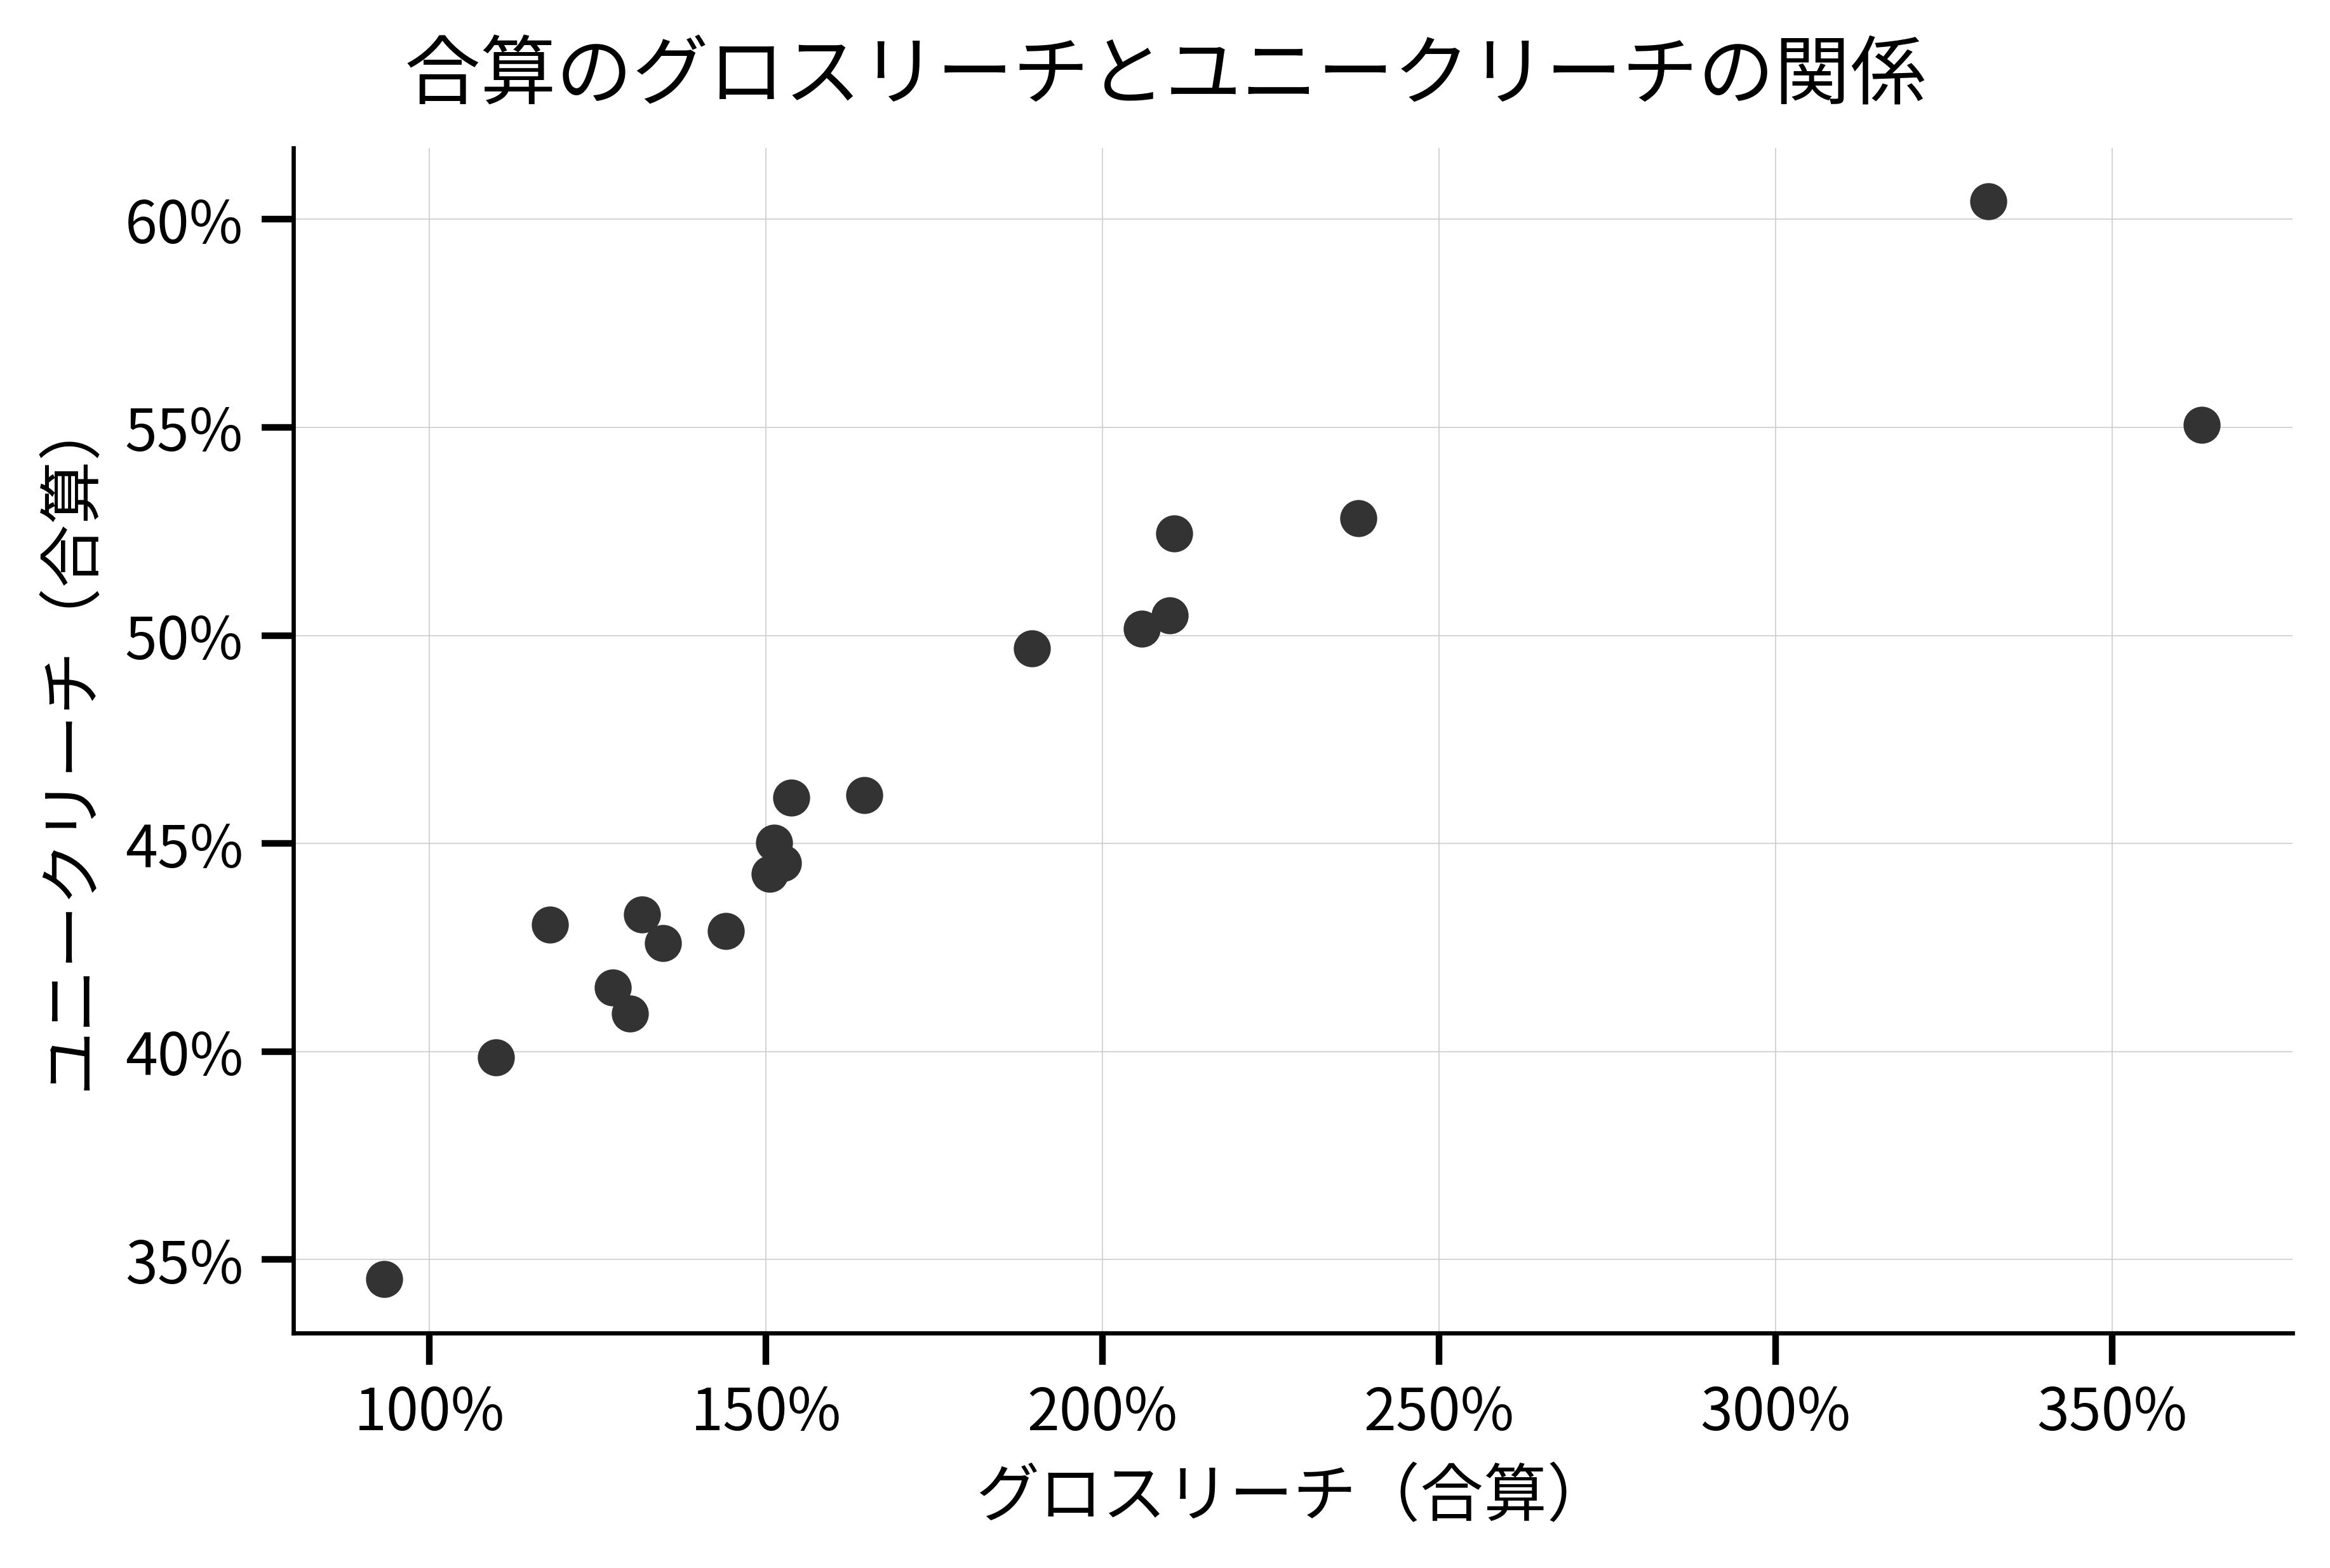

In [4]:
def plot_total_reach(
    g: np.ndarray | pl.Series,
    r: np.ndarray | pl.Series,
    title: str,
) -> tuple[Figure, Axes]:
    """合算のグロスリーチとユニークリーチの関係を可視化"""

    fig, ax = plt.subplots()
    ax.scatter(g, r)
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(
        xlabel="グロスリーチ（合算）",
        ylabel="ユニークリーチ（合算）",
    )
    fig.suptitle(title)

    return fig, ax


# 合算のグロスリーチに占める媒体1のグロスリーチの割合
df_total_reach = df_total_reach.with_columns(g_share_1=pl.col.g_1 / pl.col.g)

# 　可視化
fig, ax = plot_total_reach(
    g=df_total_reach["g"],
    r=df_total_reach["r"],
    title="合算のグロスリーチとユニークリーチの関係",
)

In [5]:
# sciki-learnの入力形式に合わせて変換
G = df_total_reach[["g_1", "g_2"]].to_numpy()
r = df_total_reach["r"].to_numpy()

In [6]:
from sklearn.ensemble import RandomForestRegressor

# モデルの準備
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

In [7]:
from sklearn.model_selection import cross_val_predict

# Leave-One-Out Cross Validationによる予測結果
cv = r.shape[0]
r_pred_rf = cross_val_predict(estimator=rf, X=G, y=r, cv=cv, n_jobs=-1)

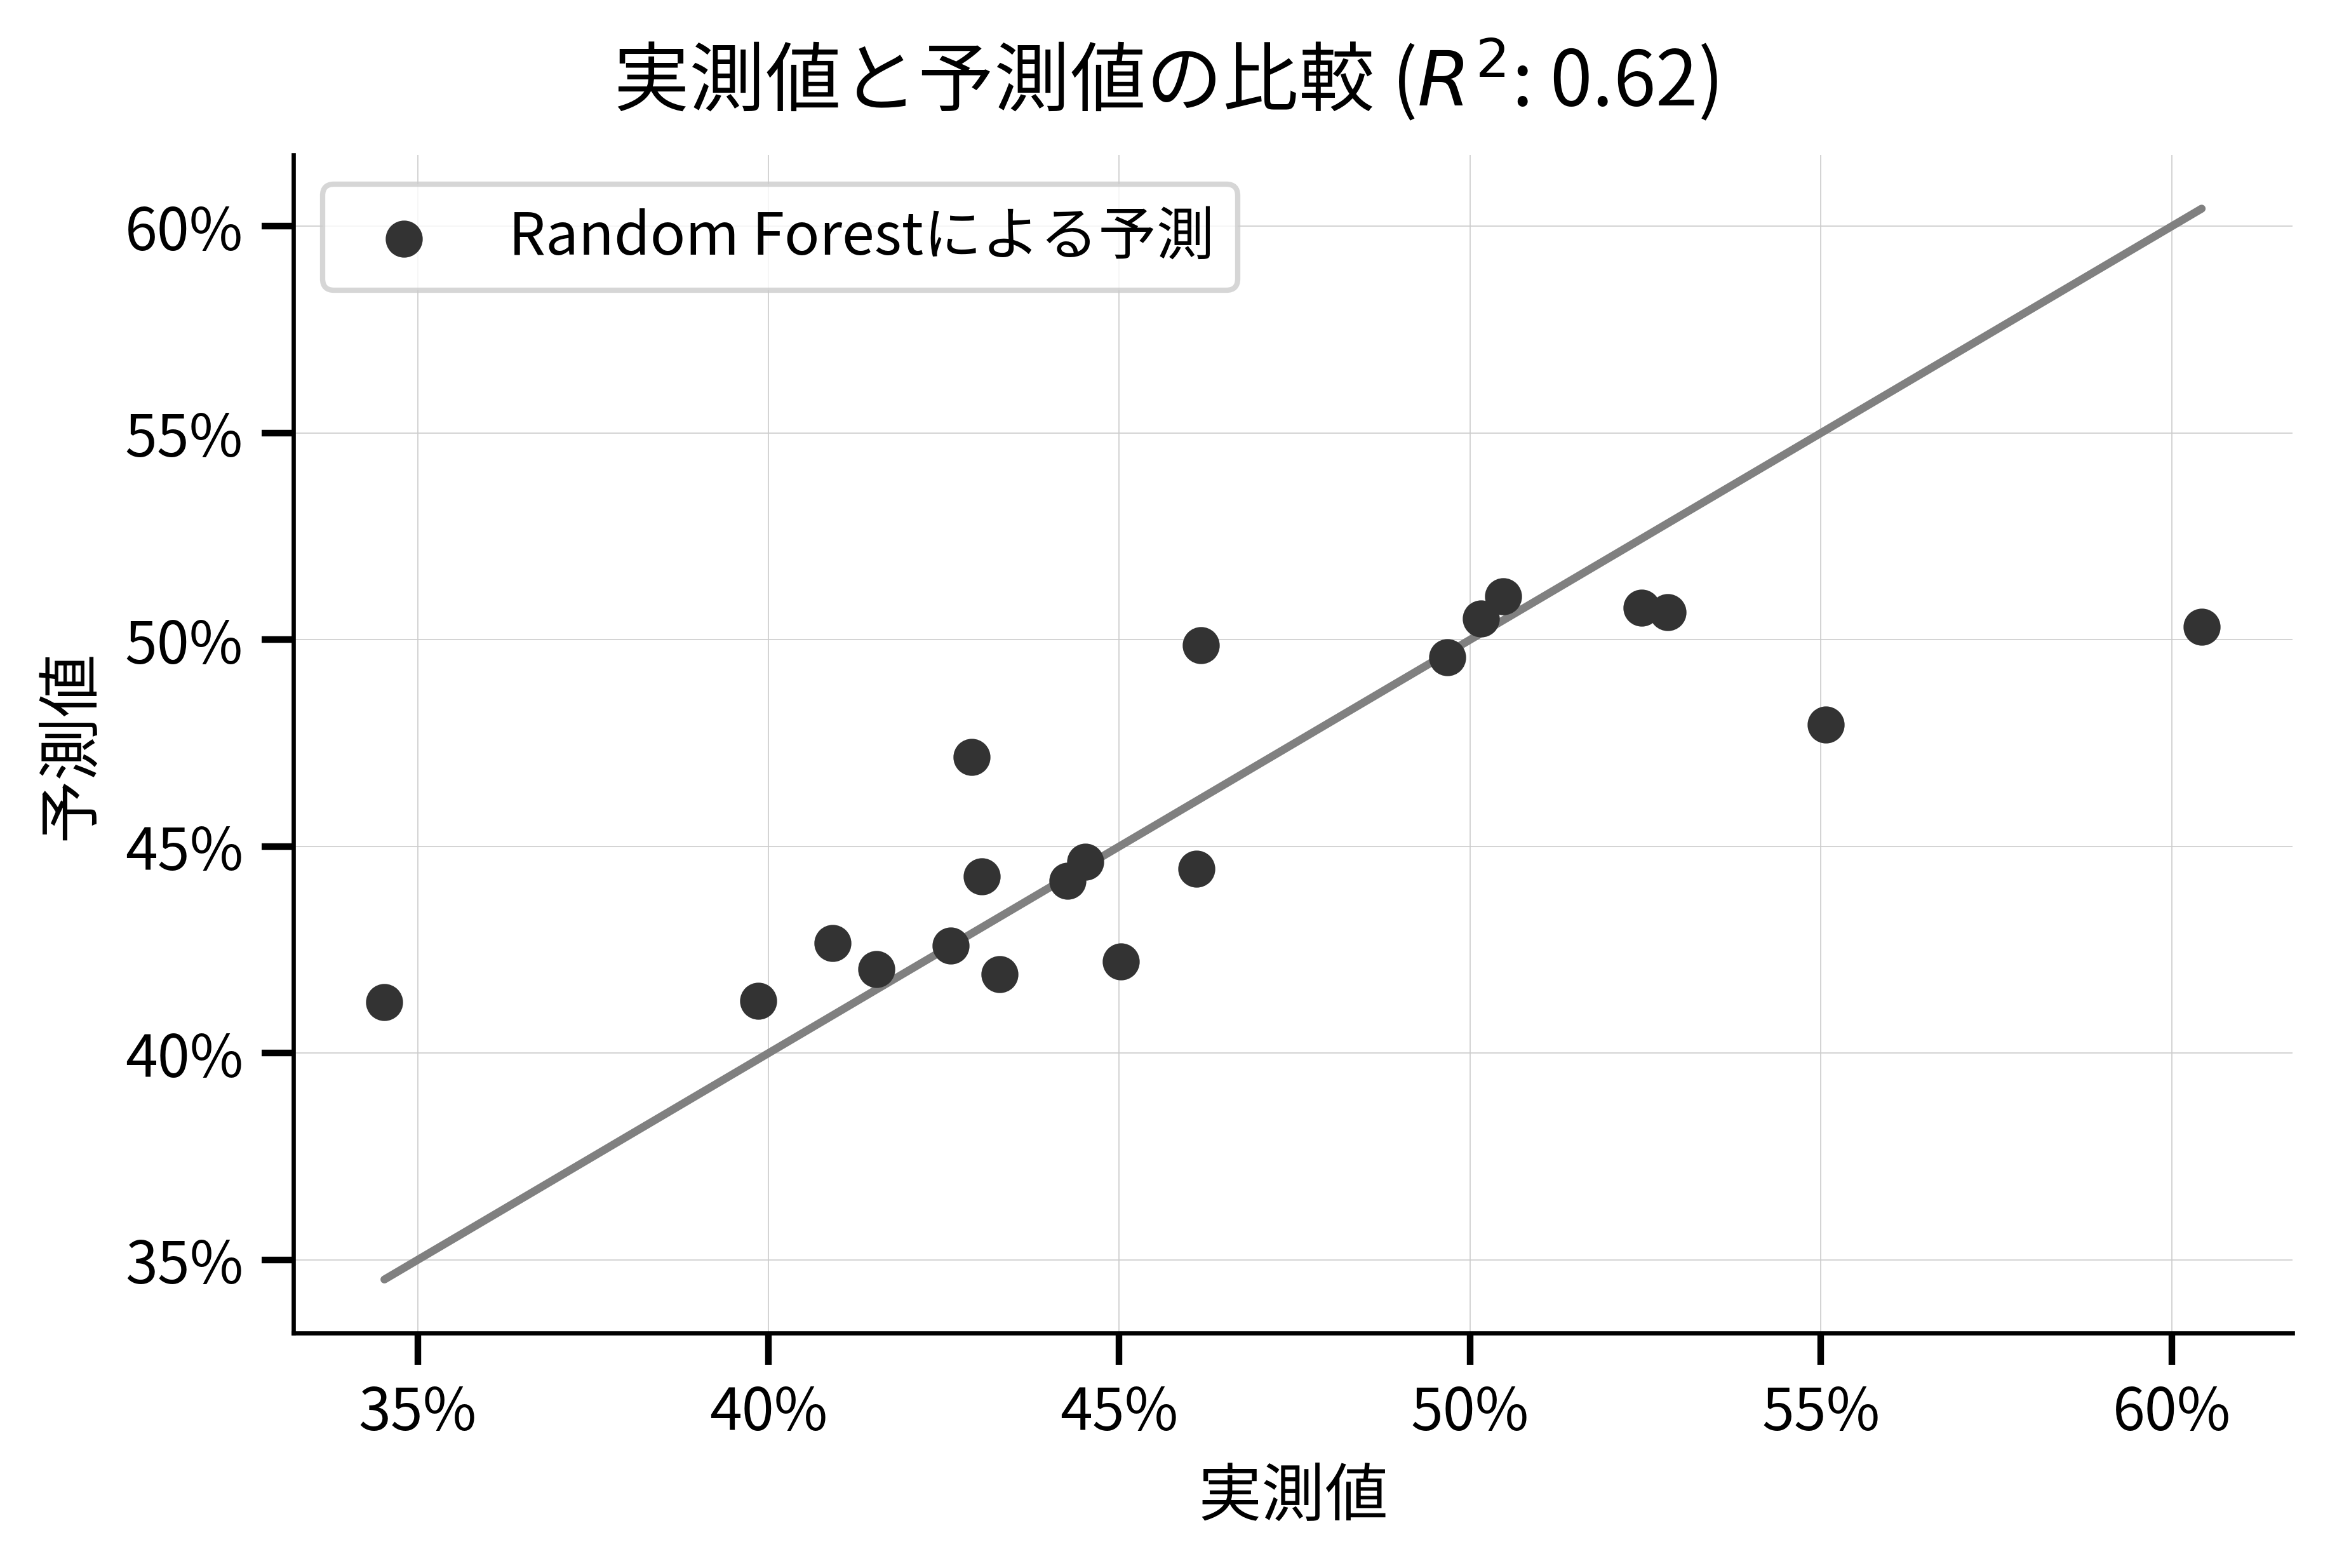

In [8]:
from sklearn.metrics import r2_score  # 決定係数


def plot_compare_actual_prediction(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    prediction_label: str,
    title: str,
) -> tuple[Figure, Axes]:
    """予測値と実測値を比較"""

    # 決定係数
    r2 = r2_score(y_true=y_true, y_pred=y_pred)

    y = np.concatenate([y_true, y_pred])
    x = np.linspace(y.min(), y.max(), 100)  # 対角線

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, label=prediction_label, zorder=2)
    ax.plot(x, x, c=".5", zorder=1)
    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="実測値", ylabel="予測値")
    fig.suptitle(f"{title} ($R^2$: {r2:.2f})")

    return fig, ax


# 可視化
fig, ax = plot_compare_actual_prediction(
    y_true=r,
    y_pred=r_pred_rf,
    prediction_label="Random Forestによる予測",
    title="実測値と予測値の比較",
)

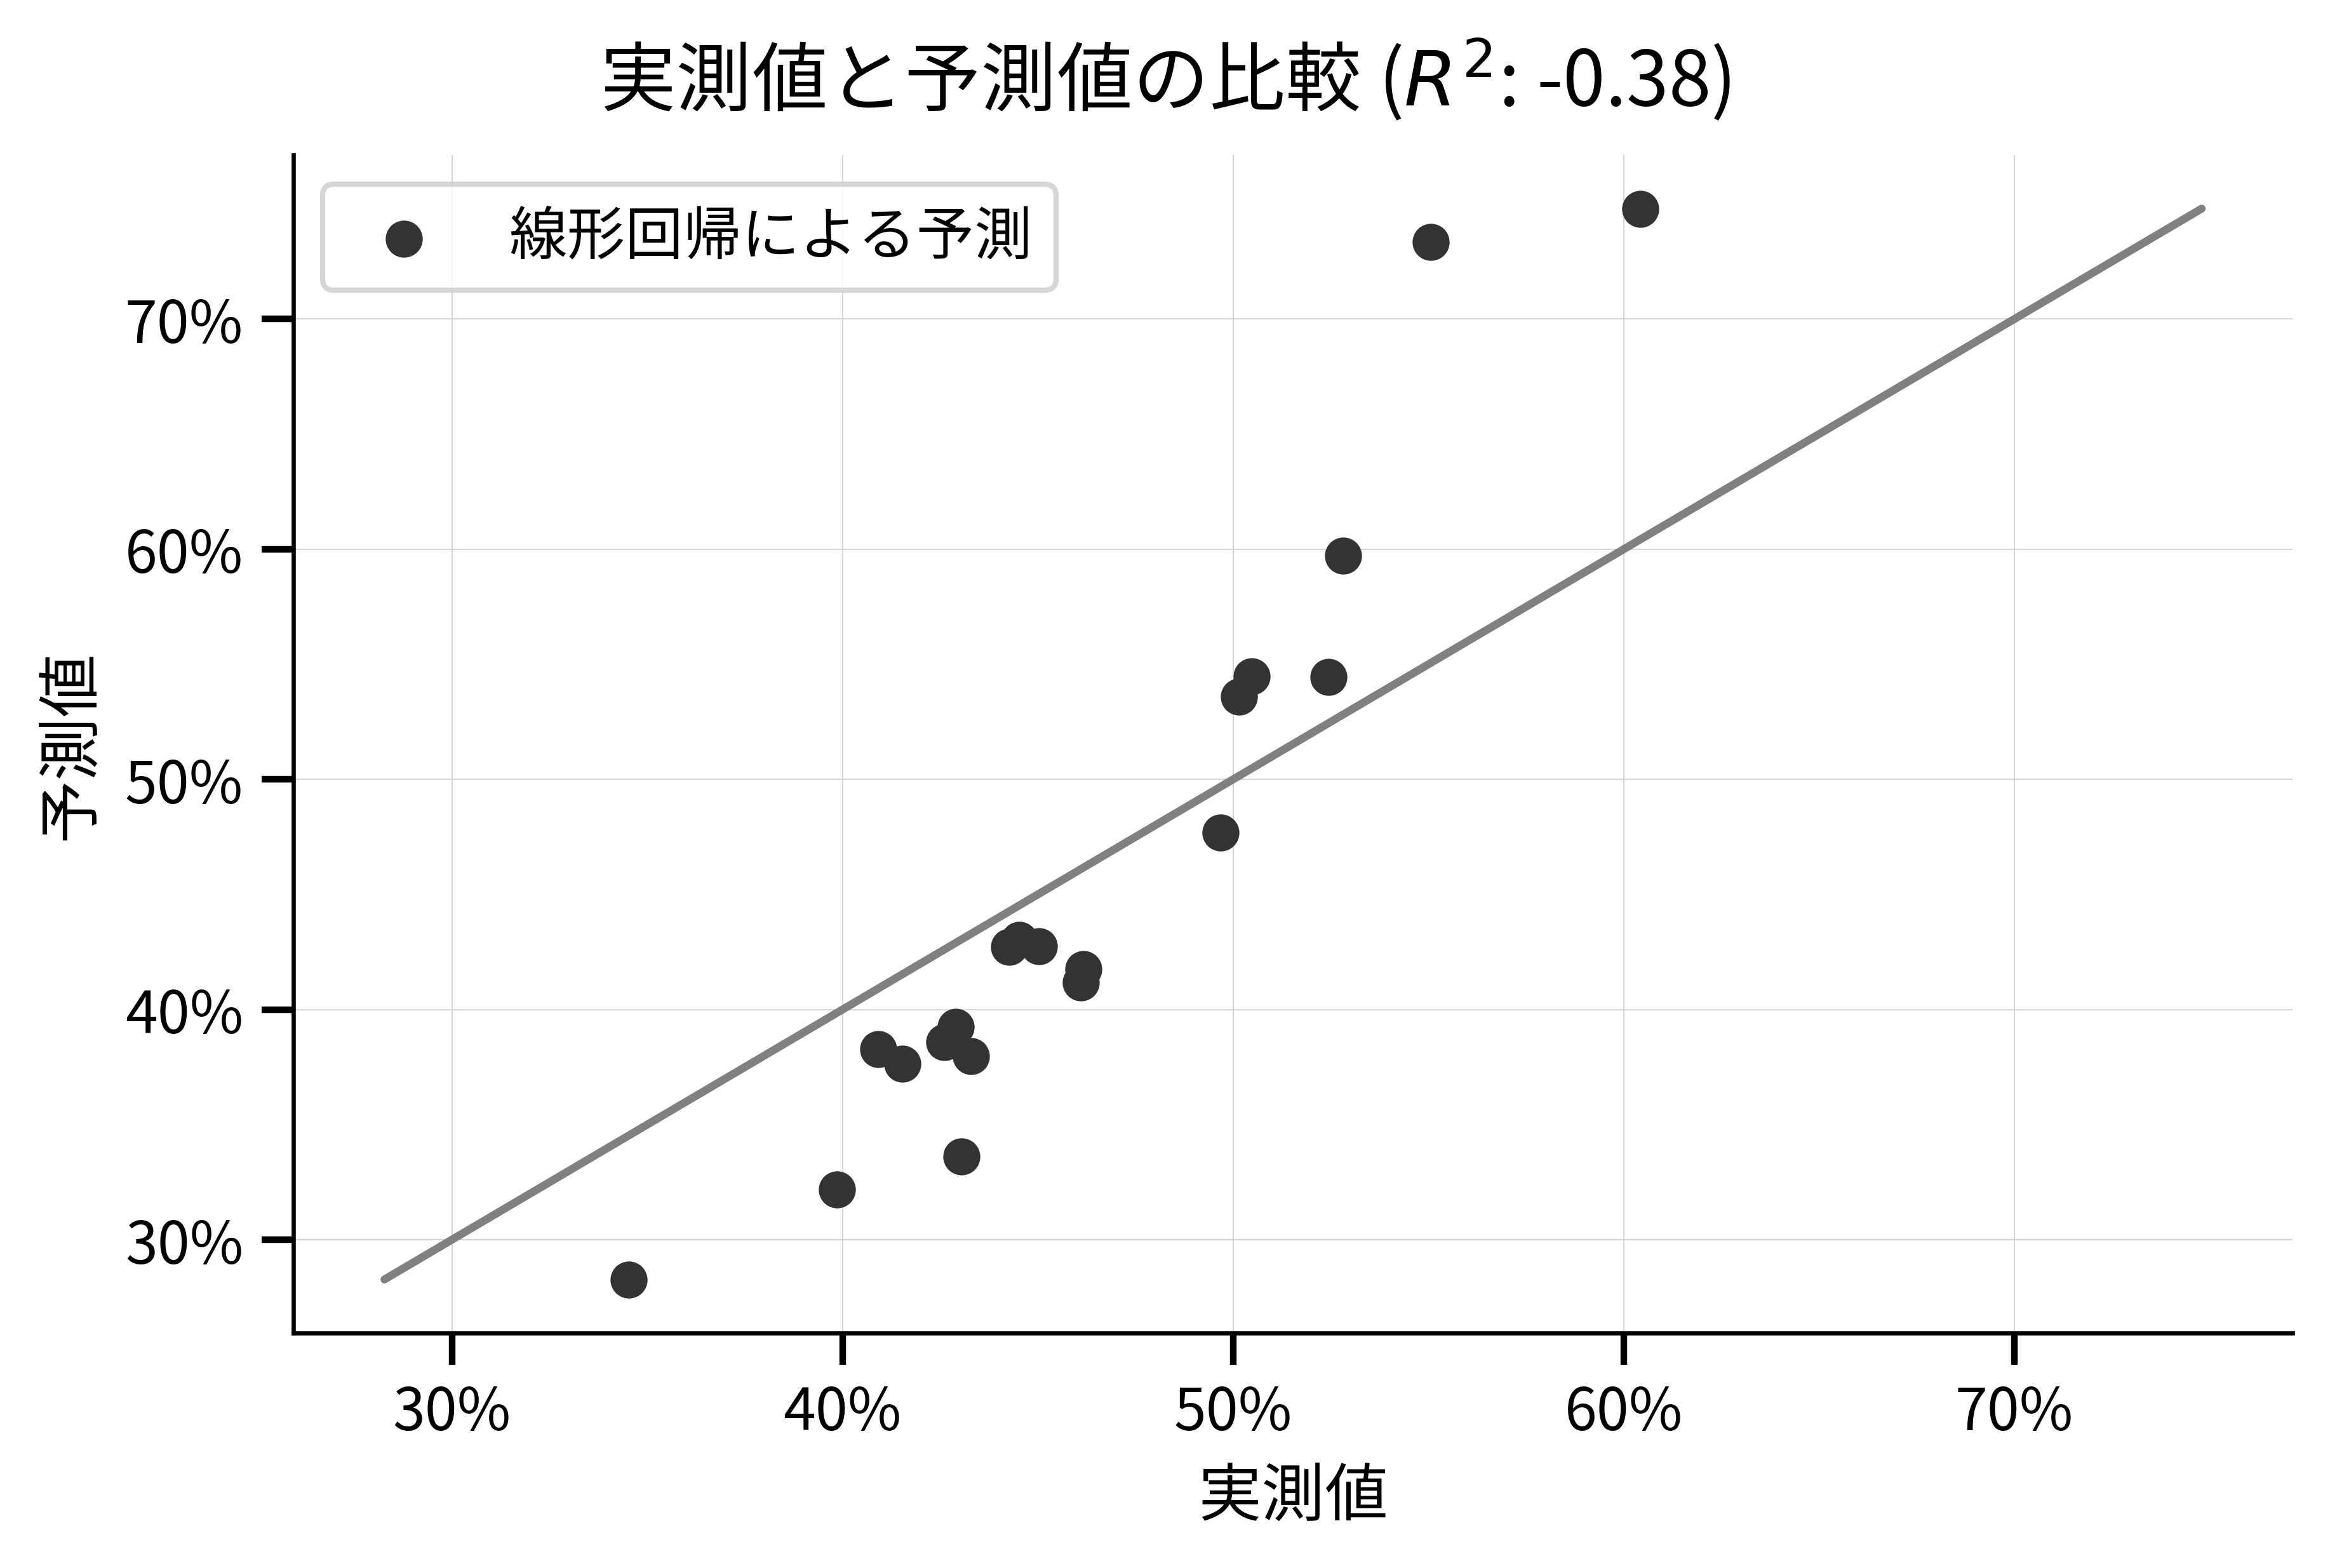

In [9]:
from sklearn.linear_model import LinearRegression

# 切片なしの線形回帰モデルの準備
lr = LinearRegression(fit_intercept=False)

# Leave-One-Out Cross Validationによる予測結果
r_pred_lr = cross_val_predict(lr, np.log1p(G), r, cv=cv, n_jobs=-1)

# 可視化
fig, ax = plot_compare_actual_prediction(
    y_true=r,
    y_pred=r_pred_lr,
    prediction_label="線形回帰による予測",
    title="実測値と予測値の比較",
)

In [10]:
# 各媒体のユニークリーチが追加されたデータの読み込み
df_total_reach_with_single_reach = pl.read_csv(
    "../data/ch04/df_total_reach_with_single_reach.csv"
)

# データの確認
df_total_reach_with_single_reach

i,g,r,g_1,g_2,r_1,r_2
i64,f64,f64,f64,f64,f64,f64
1,1.895,0.497,0.934,0.961,0.368,0.313
2,2.106,0.524,1.540,0.566,0.451,0.253
3,3.633,0.551,0.725,2.908,0.296,0.475
4,2.100,0.505,1.520,0.580,0.430,0.240
5,1.179,0.430,0.640,0.540,0.306,0.266
…,…,…,…,…,…,…
16,1.347,0.426,0.859,0.488,0.337,0.226
17,3.316,0.604,2.343,0.973,0.526,0.339
18,1.441,0.429,0.755,0.685,0.293,0.274


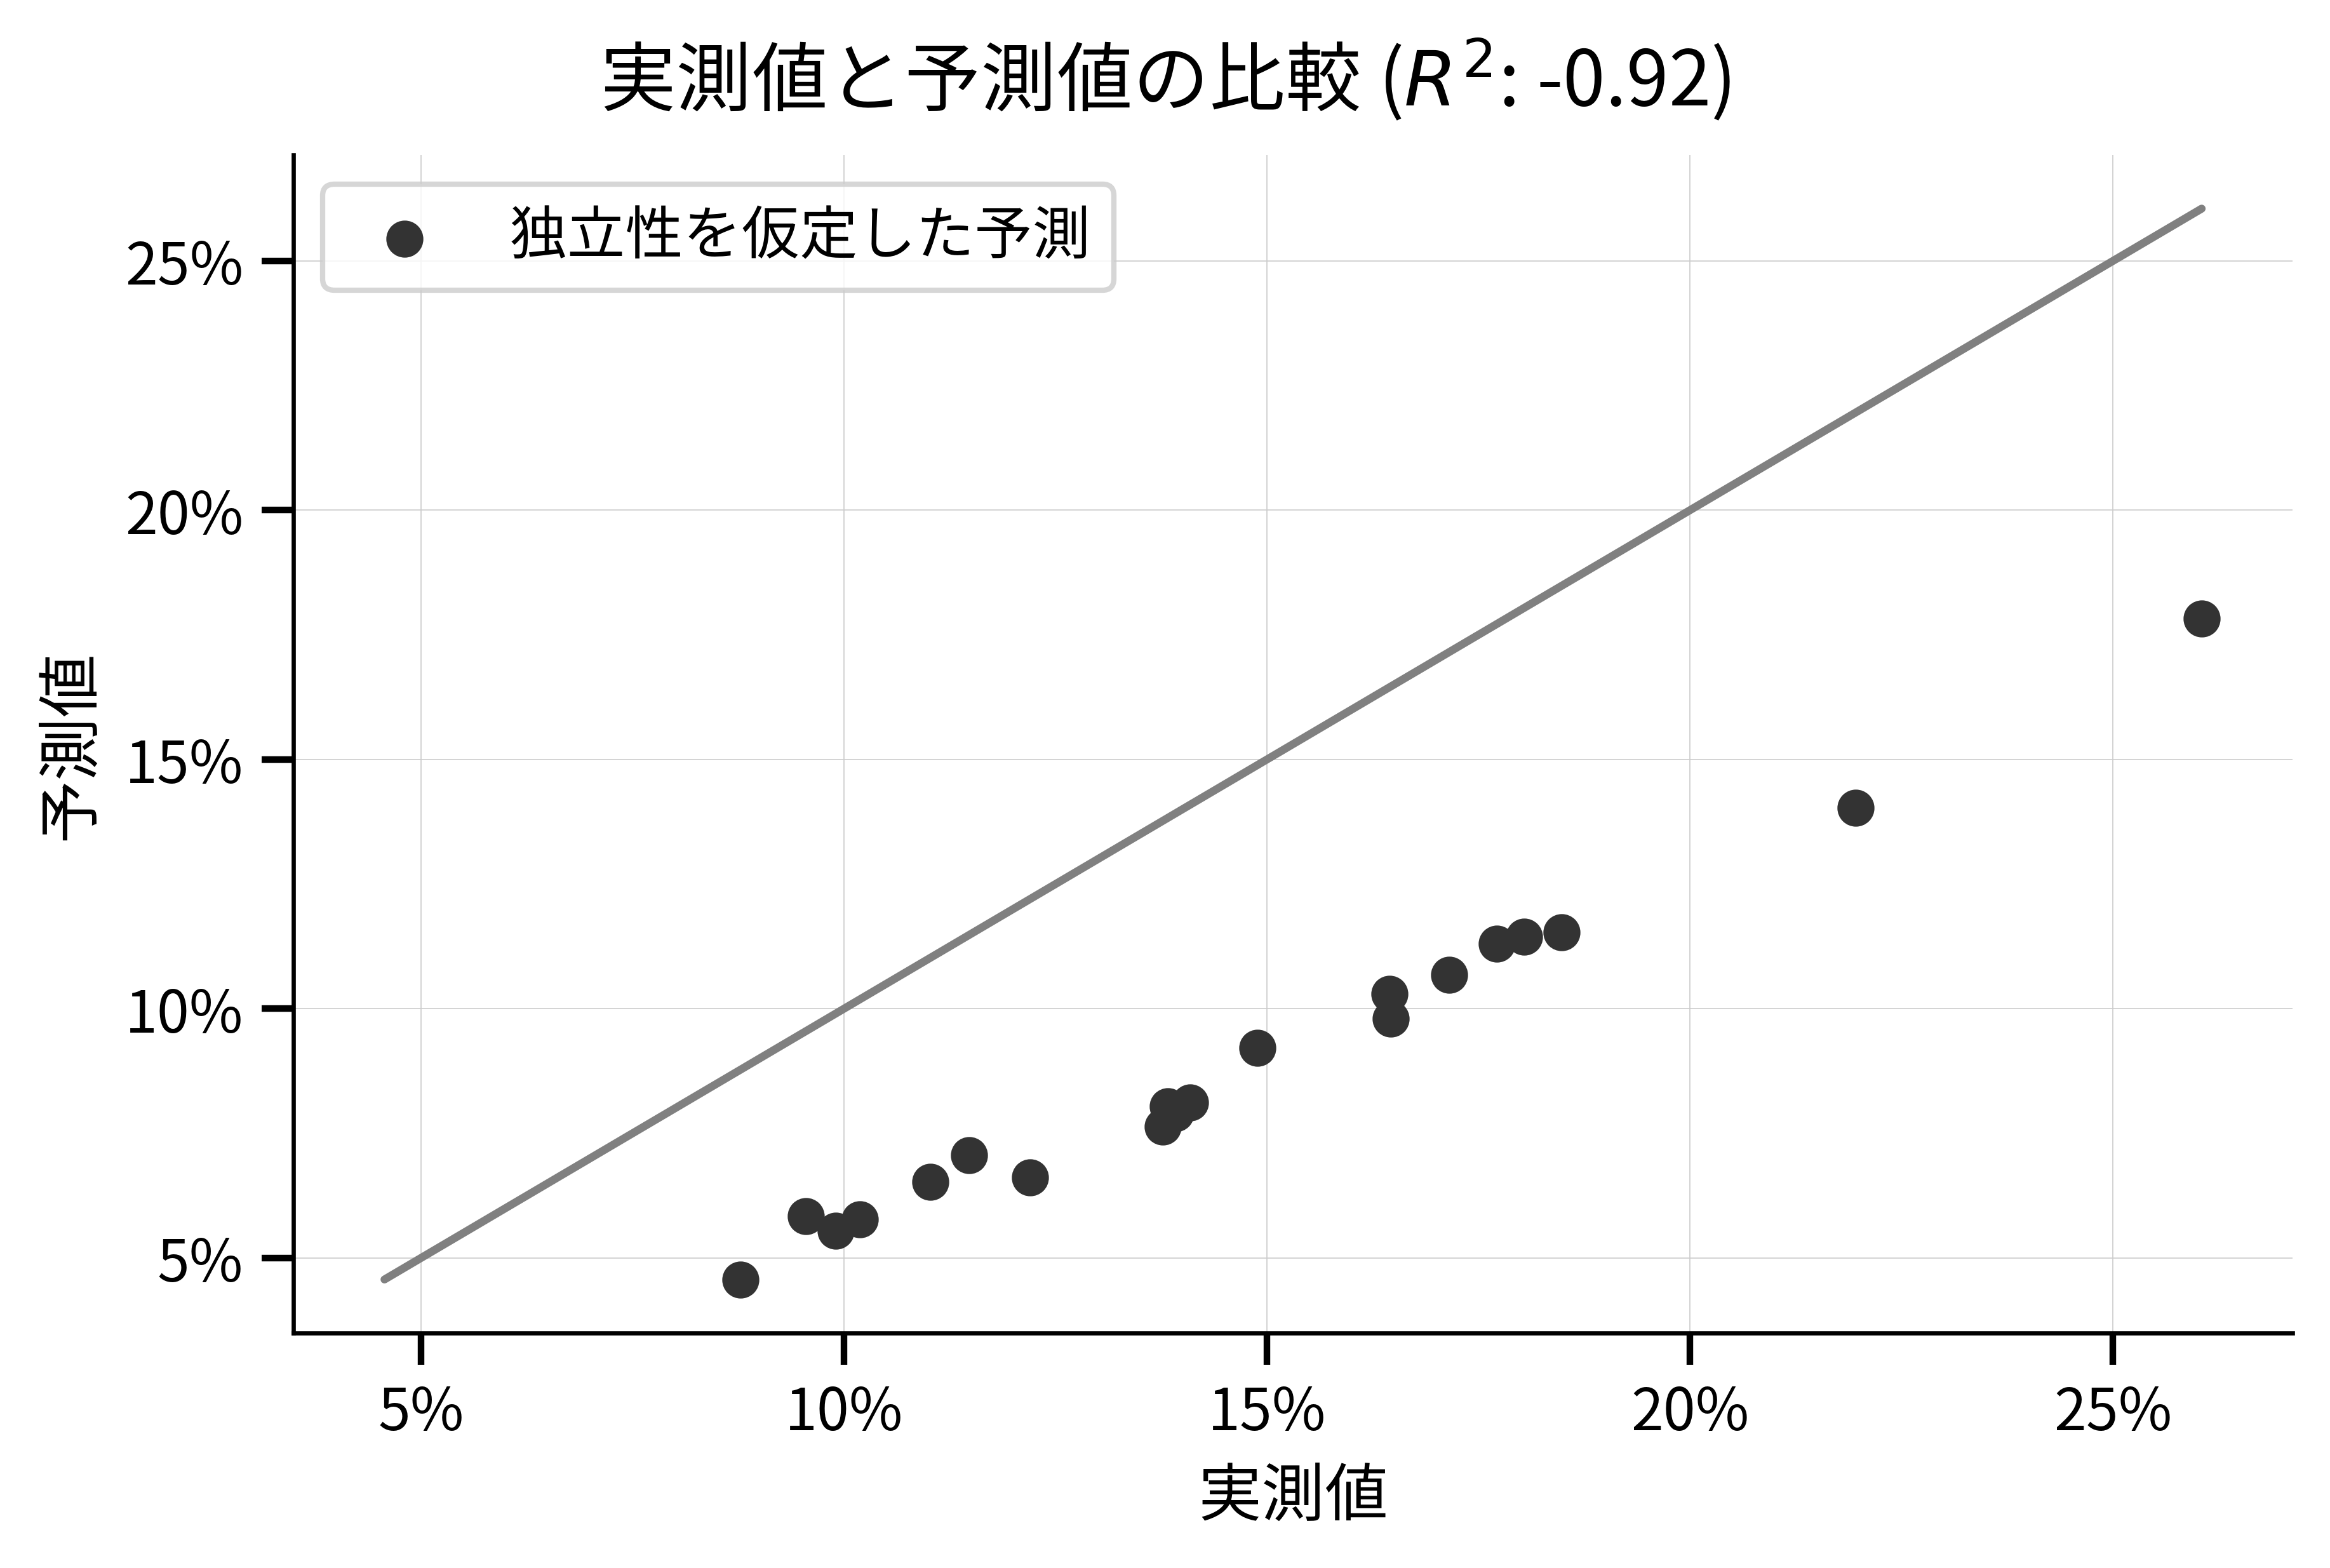

In [11]:
# 後でscikit-learnで使うのでnumpyに変換
R = df_total_reach_with_single_reach[["r_1", "r_2"]].to_numpy()

# 実際の重複リーチ。r_1 + r_2 - r_1or2 で重複部分 r_1and2 になる
r_mult = R.sum(axis=1) - r

# 独立性を仮定した重複リーチの予測値
r_mult_pred = R.prod(axis=1)

# 可視化で独立かどうかを確認
fig, ax = plot_compare_actual_prediction(
    y_true=r_mult,
    y_pred=r_mult_pred,
    prediction_label="独立性を仮定した予測",
    title="実測値と予測値の比較",
)

In [12]:
import math  # 組み合わせの数の計算にcombを使いたいので

from scipy.optimize import minimize  # 最適化
from sklearn.base import (
    BaseEstimator,
    RegressorMixin,
)  # 回帰モデルの基底クラス
from sklearn.metrics import mean_squared_error  # 二乗誤差
from sklearn.preprocessing import (
    PolynomialFeatures,
)  # 掛け算の項目を作成


class TotalReachEstimator(RegressorMixin, BaseEstimator):
    """各媒体のユニークリーチから合算のユニークリーチを予測するモデル"""

    def __init__(self):
        pass

    def _transform(self, X: np.ndarray) -> np.ndarray:
        """重複リーチを表す説明変数を追加し、符号も追加

        Args:
            X (np.ndarray): 説明変数。各媒体のユニークリーチを想定

        Returns:
            np.ndarray: 重複リーチの説明変数を追加した説明変数
        """
        # 重複リーチの説明変数を追加
        X_pf = PolynomialFeatures(
            degree=self.m_,  # 重複リーチの最大重複数
            include_bias=False,  # 切片を含めない
            interaction_only=True,  # 掛け算した項目のみに限定
        ).fit_transform(X)

        # 奇数項なら1、偶数項なら-1をかける
        signs: list[int] = []
        for k in range(1, self.m_ + 1):
            # m個からk個抜き出す組み合わせの数
            n_params = math.comb(self.m_, k)
            sign = 1 if k % 2 != 0 else -1
            signs.extend([sign] * n_params)  # 追加

        return X_pf * signs

    def _predict(self, X: np.ndarray, eta: np.ndarray) -> np.ndarray:
        """重複部分を補正して合算のユニークリーチを予測

        Args:
            X (np.ndarray): 説明変数。重複リーチを含む
            eta (np.ndarray): 重複リーチの補正係数

        Returns:
            np.ndarray: 合算のユニークリーチの予測値
        """

        # 最初のm個は重複リーチではないので、1をかける
        eta_add_ones = np.concatenate([np.ones(self.m_), eta])

        return eta_add_ones @ X.T

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """各媒体のユニークリーチと合算のユニークリーチの関係を学習

        Args:
            X (np.ndarray): 説明変数。各媒体のユニークリーチを想定
            y (np.ndarray): 目的変数。合算のユニークリーチを想定

        Returns:
            Self: 学習済モデル
        """

        # 媒体数を保存
        self.m_ = X.shape[1]

        # 重複リーチの説明変数を追加
        X_trans = self._transform(X=X)

        # 最適な補正係数etaを推定
        self.eta_ = minimize(
            fun=lambda eta: mean_squared_error(y, self._predict(X=X_trans, eta=eta)),
            x0=np.ones(2**self.m_ - self.m_ - 1),  # 初期値
            bounds=[(0, 10)] * (2**self.m_ - self.m_ - 1),  # 制約
            tol=1e-10,
        ).x

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """合算のユニークリーチを予測

        Args:
            X (np.ndarray): 説明変数。各媒体のユニークリーチを想定

        Returns:
            np.ndarray: 合算のユニークリーチの予測値
        """

        # 重複リーチの説明変数を追加
        X_trans = self._transform(X=X)

        return self._predict(X=X_trans, eta=self.eta_)


In [13]:
# 全データで学習して補正係数を推定
tre = TotalReachEstimator().fit(R, r)

# 補正係数を確認
tre.eta_.round(2)[0]

1.61

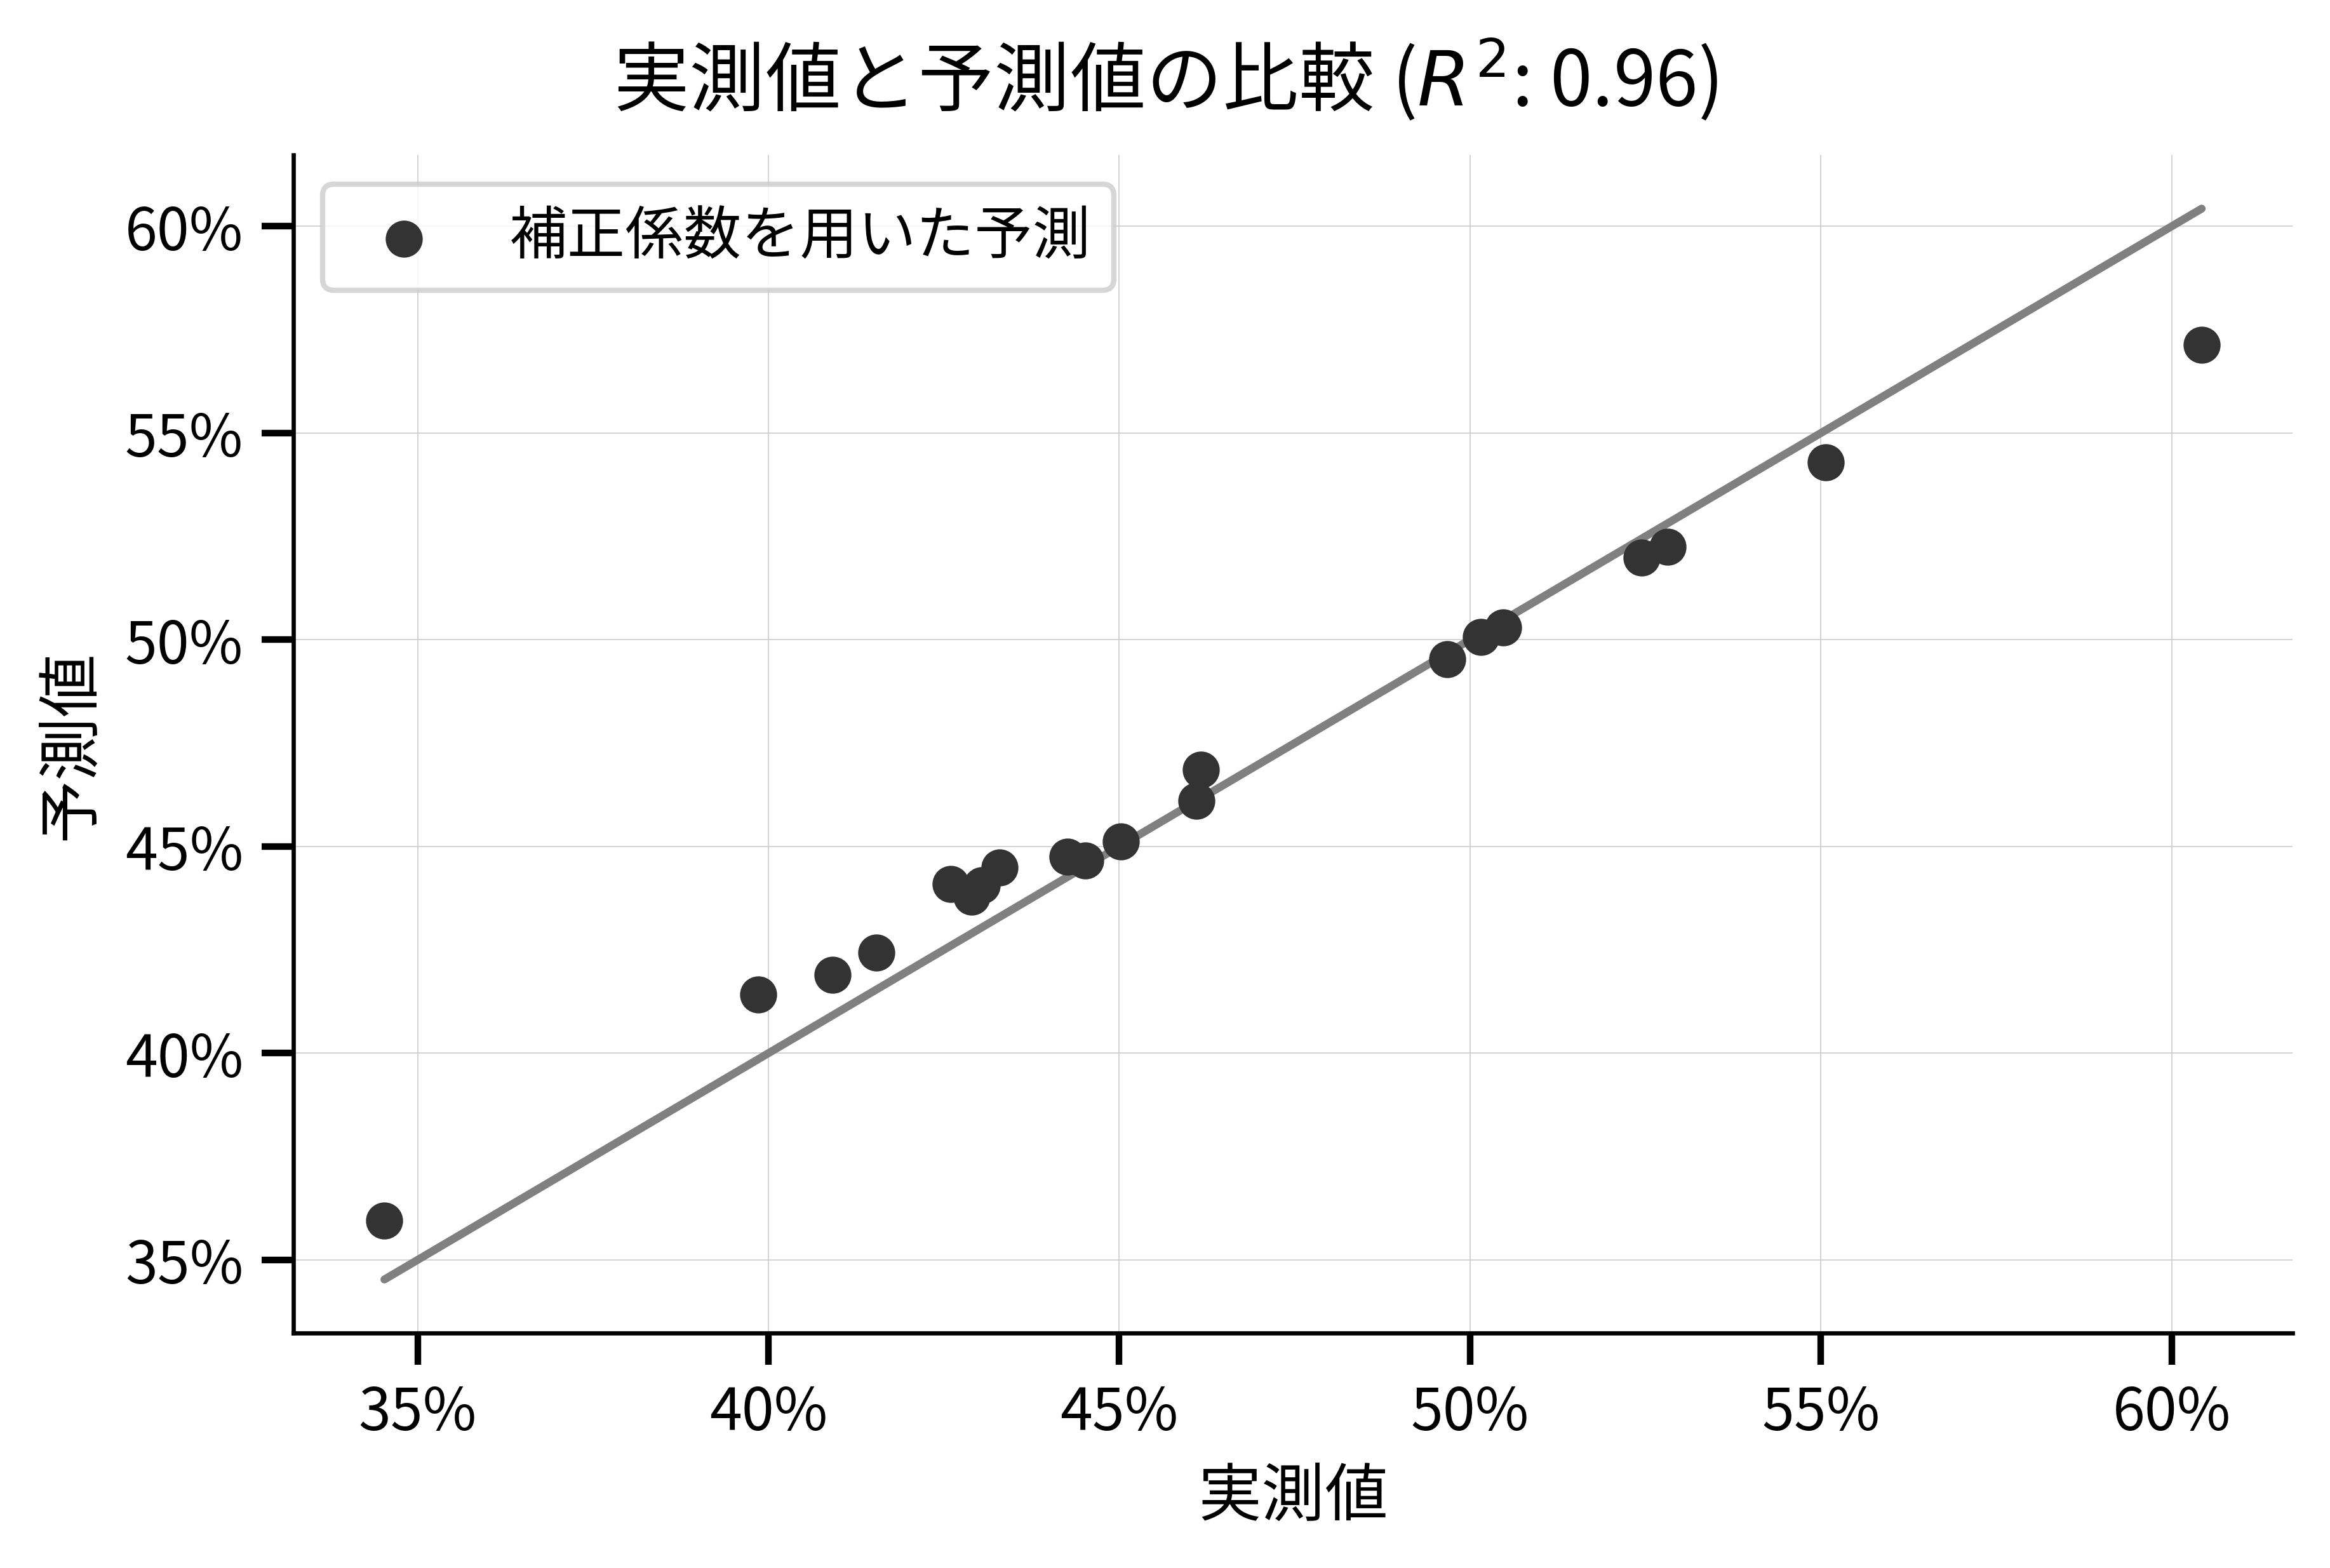

In [14]:
# Leave-One-Out Cross Validationによる予測結果
tre = TotalReachEstimator()
r_pred_tre = cross_val_predict(tre, R, r, cv=cv)

# 予測精度の可視化
fig, ax = plot_compare_actual_prediction(
    y_true=r,
    y_pred=r_pred_tre,
    prediction_label="補正係数を用いた予測",
    title="実測値と予測値の比較",
)

In [15]:
from scipy.optimize import minimize_scalar  # 最適化
from scipy.stats import nbinom  # 負の二項分布


class UniqueReachEstimator(RegressorMixin, BaseEstimator):
    """グロスリーチからユニークリーチを予測するモデル"""

    def __init__(self) -> None:
        pass

    @staticmethod
    def _predict(g: np.ndarray, alpha: float) -> np.ndarray:
        """負の二項分布を仮定したリーチカーブの予測

        Args:
            g (np.ndarray): グロスリーチ
            alpha (float): 負の二項分布のパラメータ

        Returns:
            np.ndarray: リーチの予測値
        """

        return 1 - nbinom.pmf(k=0, p=alpha / (g + alpha), n=alpha)

    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """グロスリーチとユニークリーチの関係を学習

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定
            y (np.ndarray): 目低変数。ユニークリーチを想定

        Returns:
            Self: 学習済みモデル
        """

        # 二乗誤差を最小化するalphaを推定して保存
        self.alpha_: float = minimize_scalar(
            fun=lambda alpha: mean_squared_error(
                y, self._predict(g=X, alpha=alpha)
            ),  # 最小化したい関数
            bounds=(0.01, 100),  # 推定範囲。alphaは0より大きい
        ).x

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """学習済みのパラメータを使ってユニークリーチを予測

        Args:
            X (np.ndarray): 説明変数。グロスリーチを想定

        Returns:
            np.ndarray: ユニークリーチの予測値
        """

        return self._predict(g=X, alpha=self.alpha_)

In [16]:
# 媒体数
m = R.shape[1]

# 予測値を格納する変数。shapeが(20, 2)になっていることに注意
R_pred_ure = np.zeros_like(R)
for j in range(m):
    # Leave-One-Out Cross Validationによる予測結果
    ure = UniqueReachEstimator()
    R_pred_ure[:, j] = cross_val_predict(ure, G[:, j], R[:, j], cv=cv, n_jobs=-1)

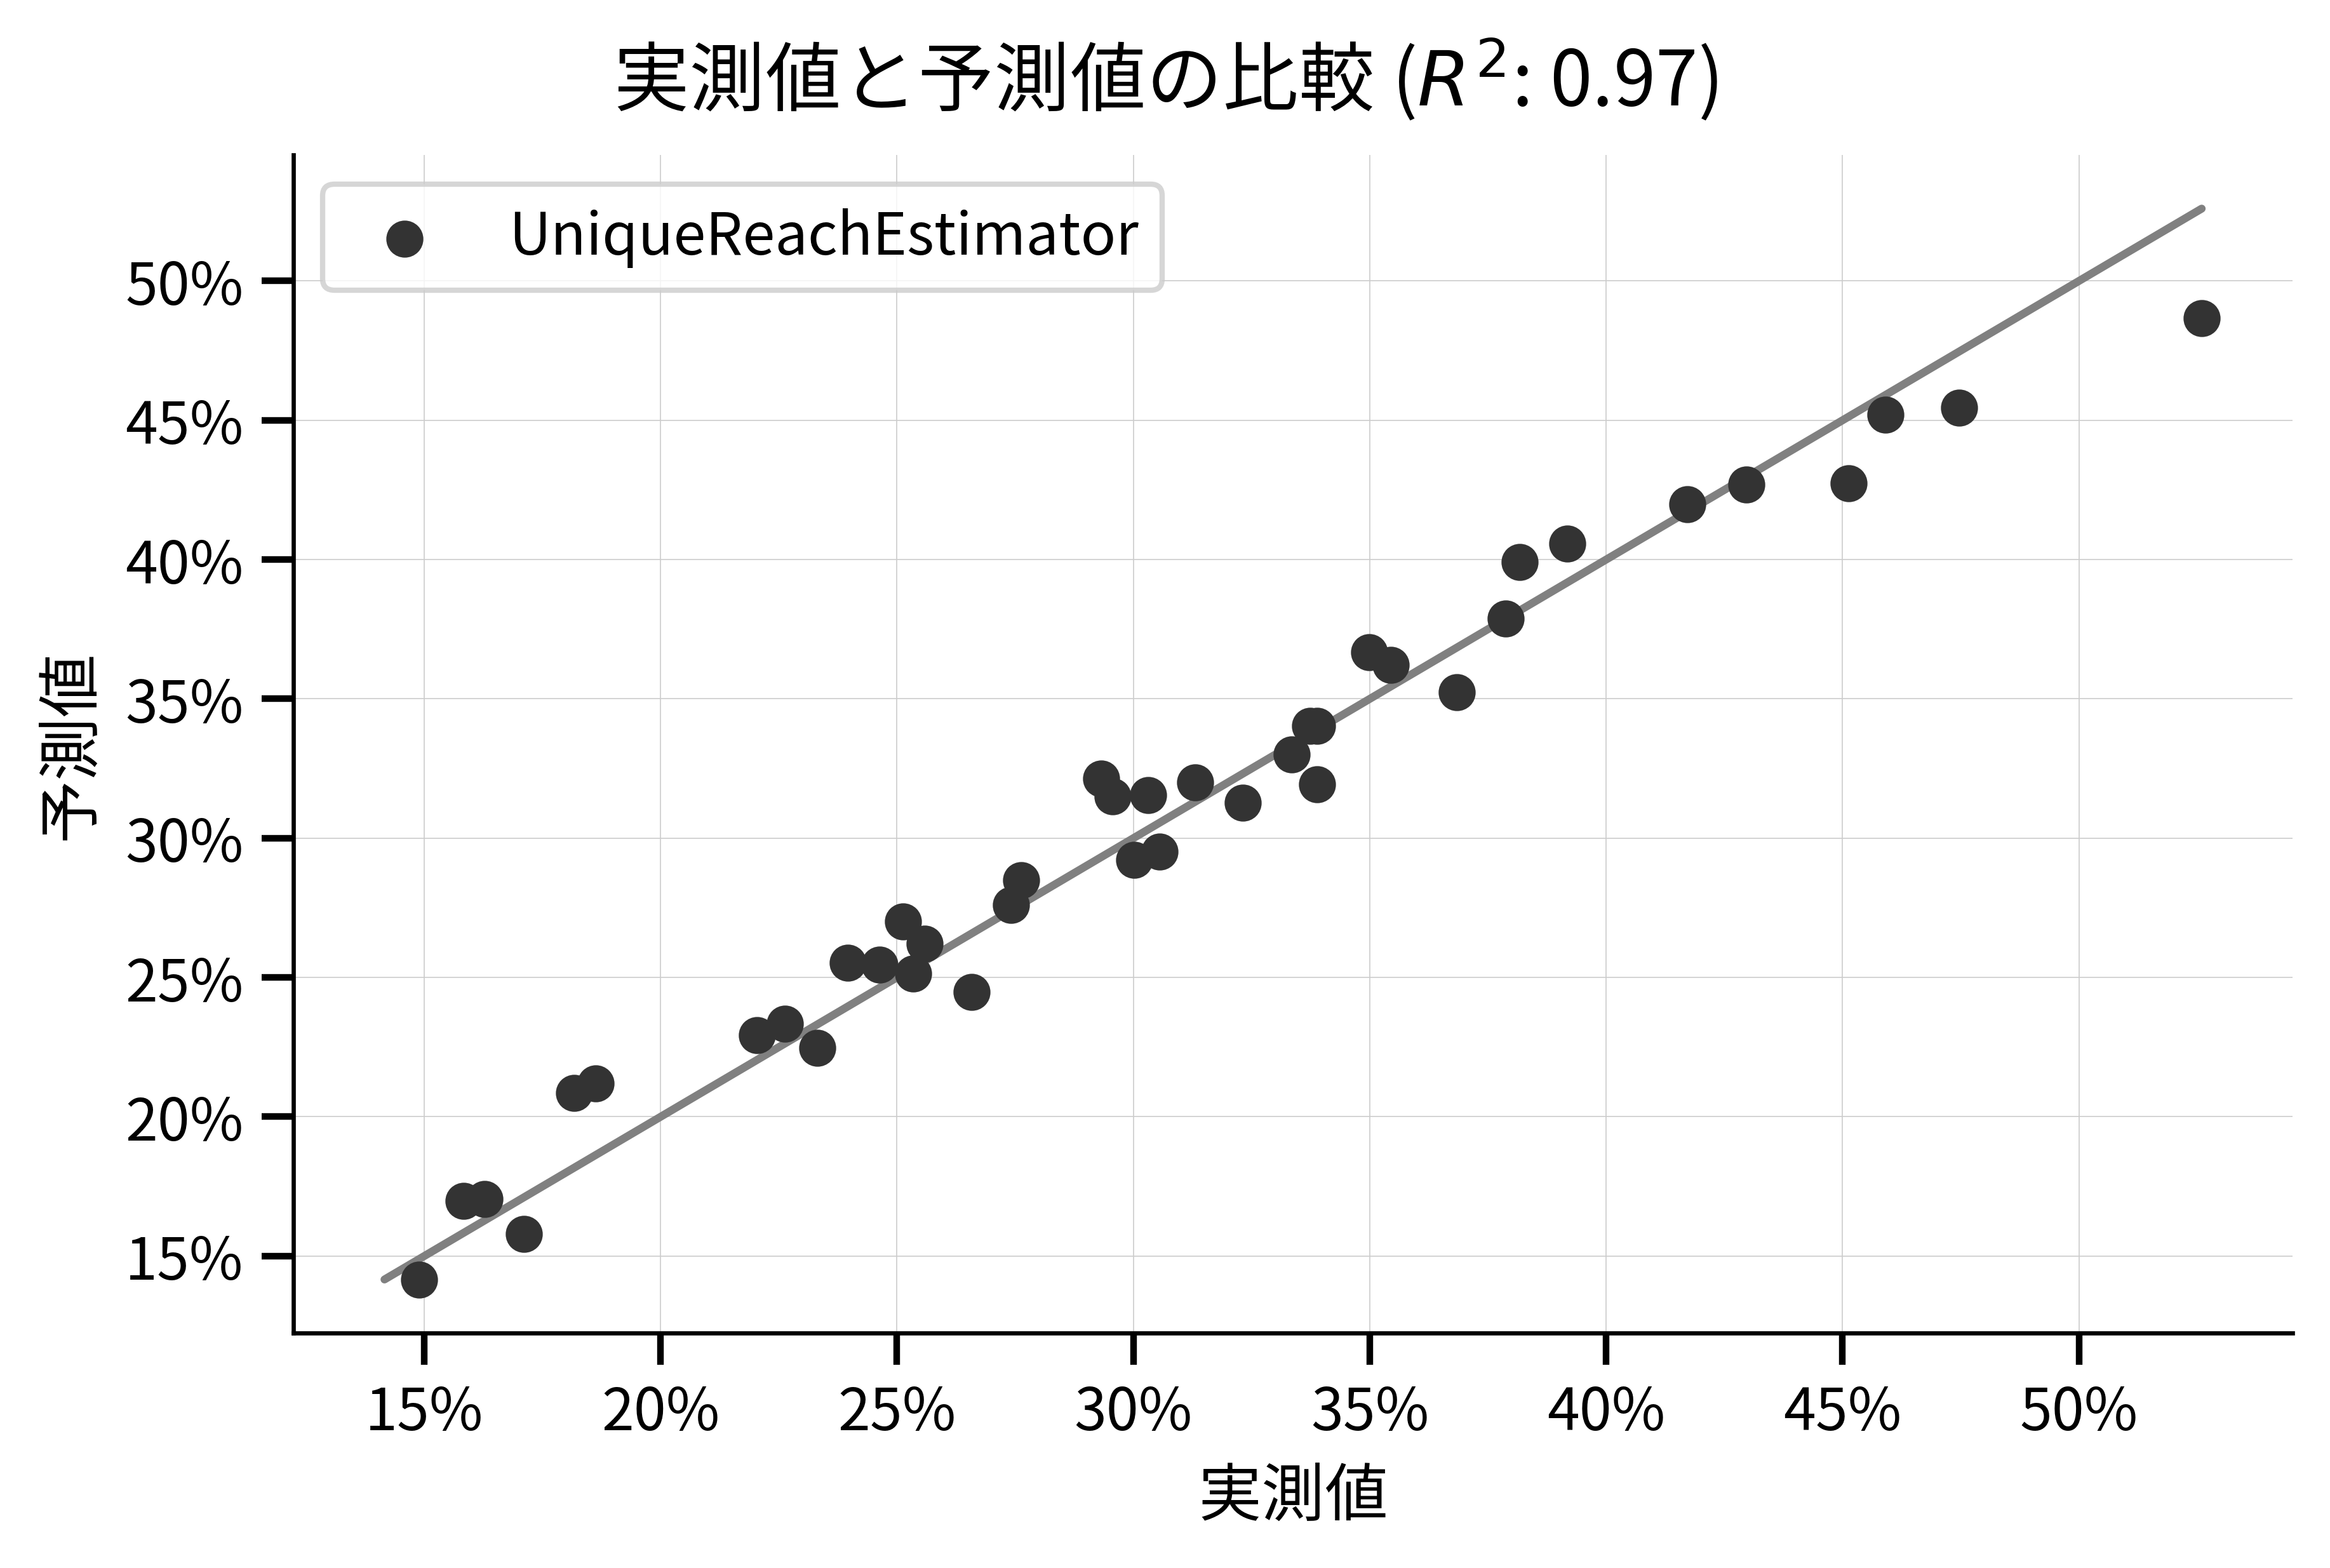

In [17]:
# 媒体が2つあるので、実測値Rも予測値R_pred_ureもshapeが(20, 2)のndarrayになっている
# flattenでshapeを(40, )に変換し、複数媒体をまとめて予測精度を計算する
fig, ax = plot_compare_actual_prediction(
    y_true=R.flatten(),
    y_pred=R_pred_ure.flatten(),
    prediction_label="UniqueReachEstimator",
    title="実測値と予測値の比較",
)

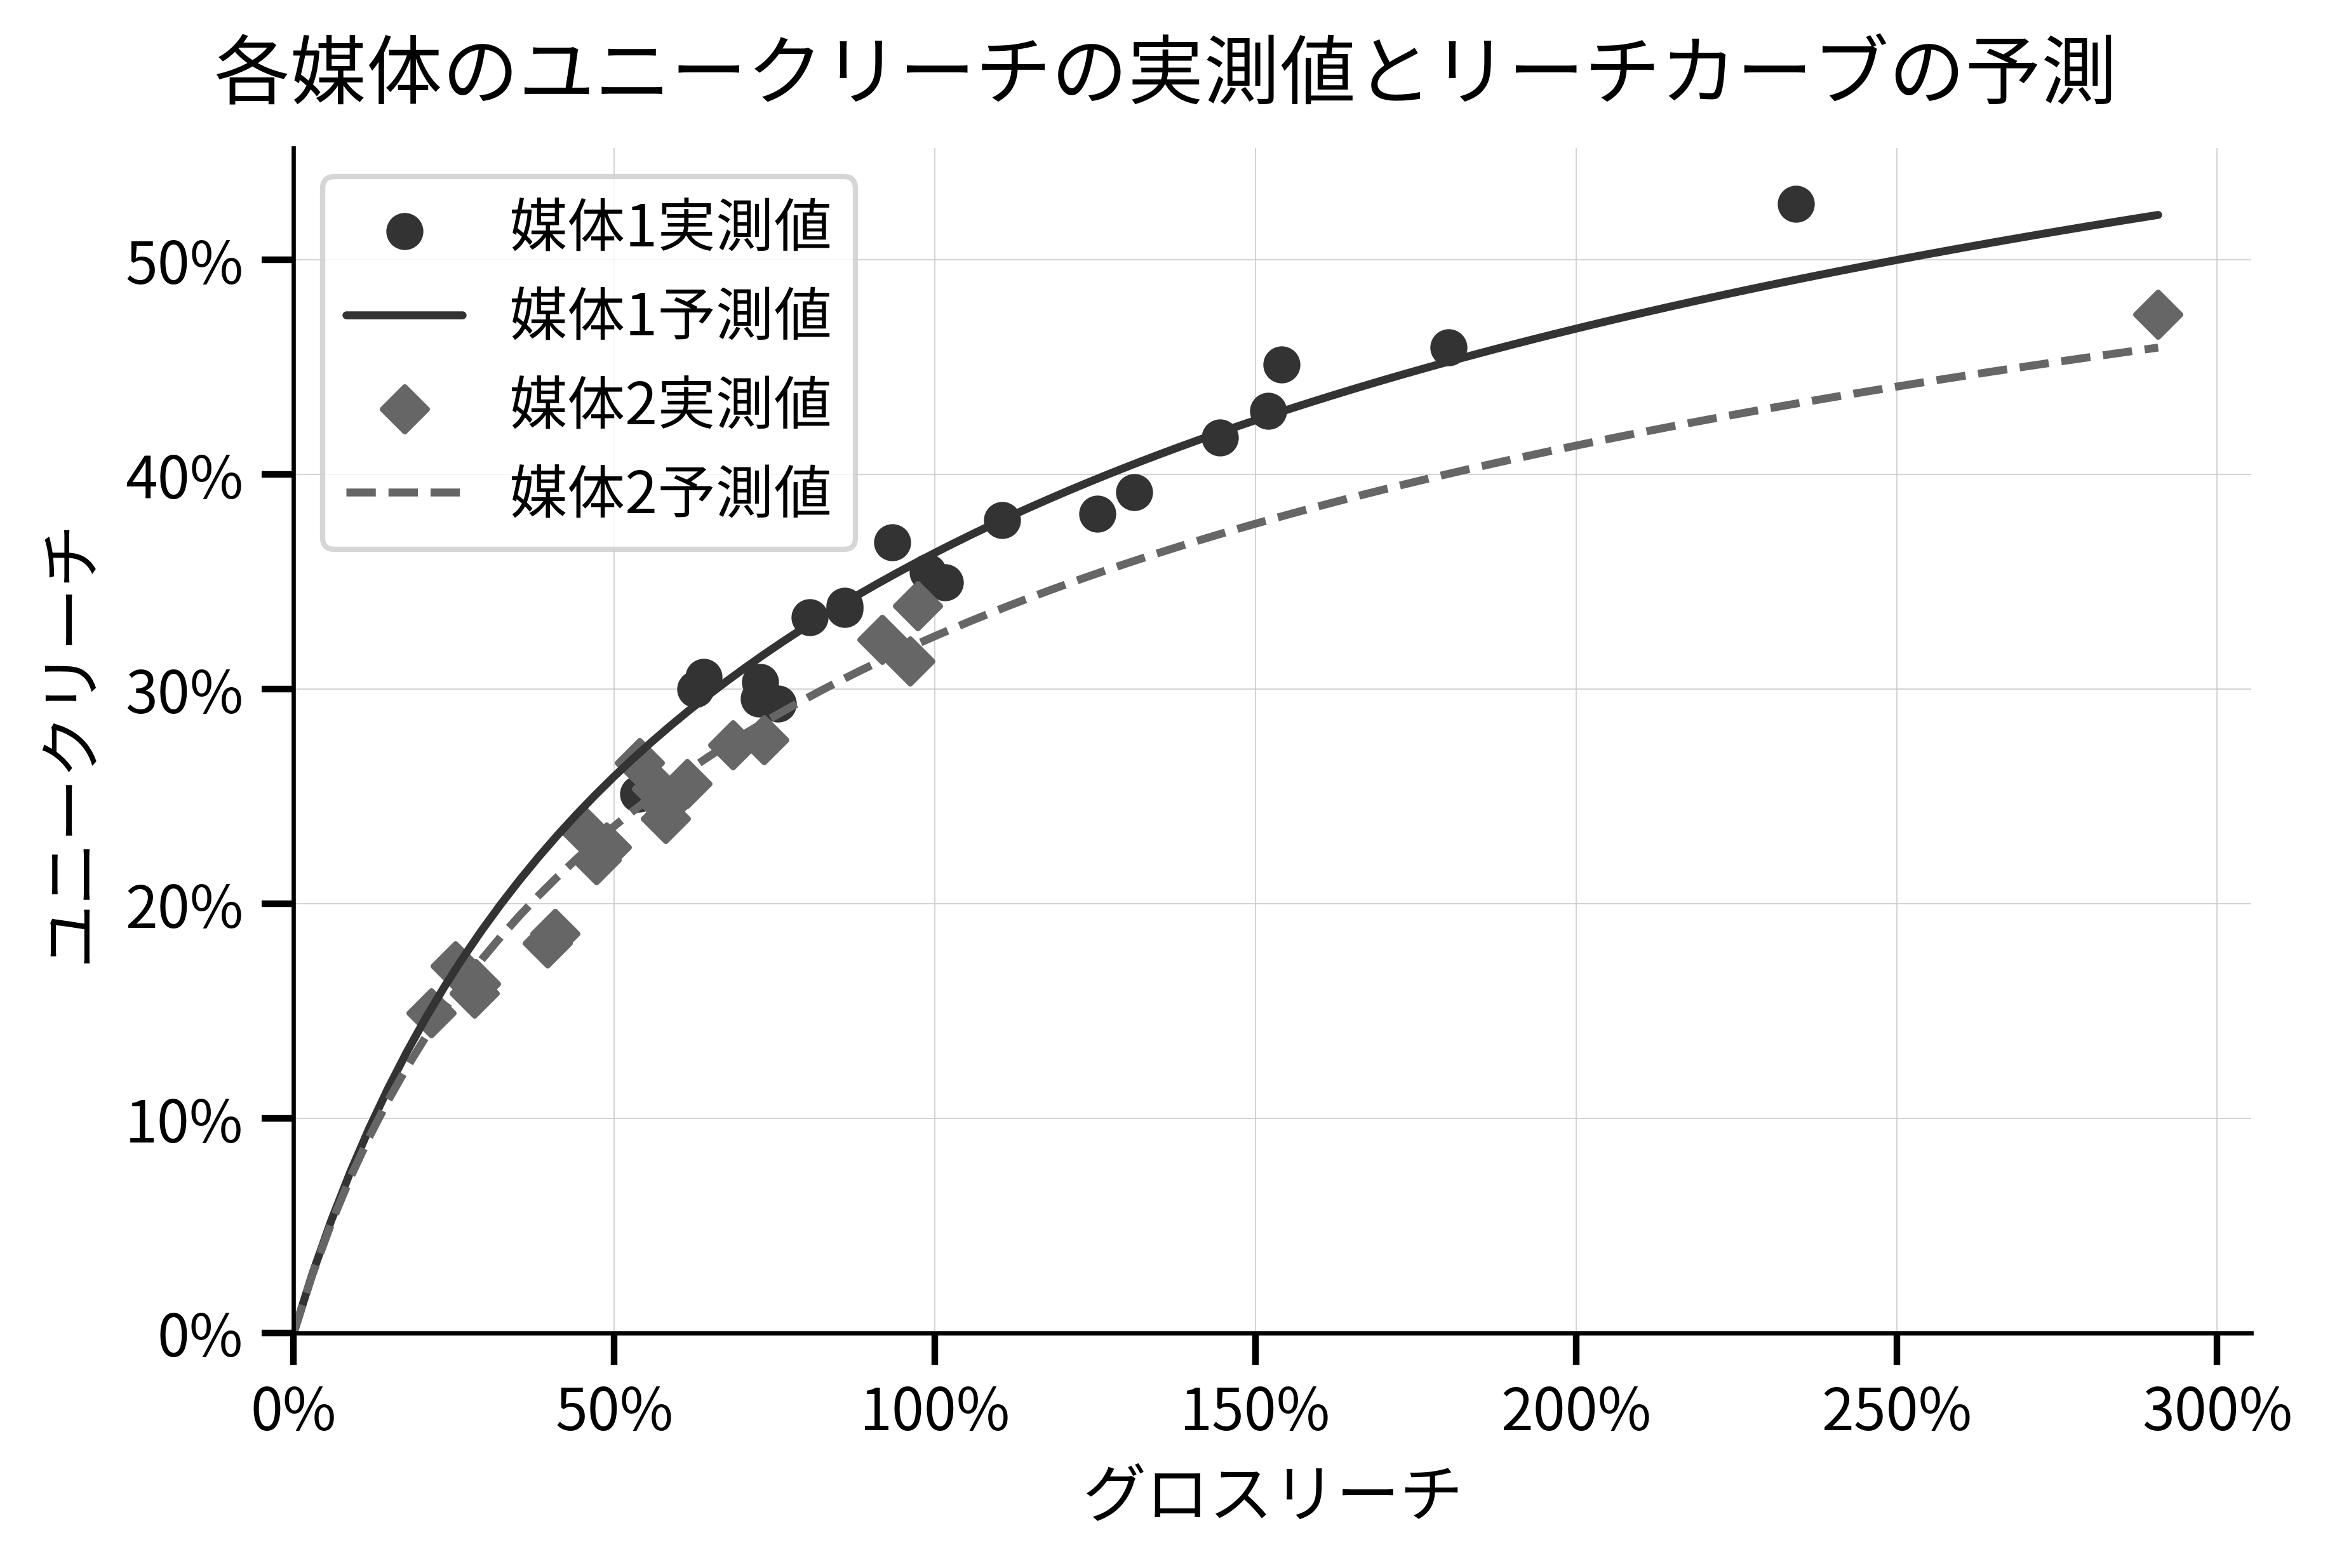

In [18]:
def plot_unique_reach_with_prediction(
    G: np.ndarray,
    R: np.ndarray,
    estimators: list[UniqueReachEstimator],
) -> tuple[Figure, Axes]:
    """各媒体のユニークリーチの実測値とリーチカーブを可視化"""

    fig, ax = plt.subplots()

    # 予測結果
    g = np.linspace(0, G.max(), num=100)

    # 媒体ごとに実際のユニークリーチと推定されたリーチカーブをプロット
    m = G.shape[1]
    markers = ["o", "D", "^", "x"]
    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for j in range(m):
        ax.scatter(
            G[:, j],
            R[:, j],
            marker=markers[j % m],
            label=f"媒体{j+1}実測値",
            zorder=1,
        )
        ax.plot(
            g,
            estimators[j].predict(g),
            linestyle=linestyles[j % m],
            label=f"媒体{j+1}予測値",
            zorder=2,
        )

    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set(xlabel="グロスリーチ", ylabel="ユニークリーチ")
    fig.suptitle("各媒体のユニークリーチの実測値とリーチカーブの予測")

    return fig, ax


# リーチカーブの可視化。全データで学習したモデルを使ってリーチカーブを予測
ur_estimators = [UniqueReachEstimator().fit(G[:, j], R[:, j]) for j in range(m)]
fig, ax = plot_unique_reach_with_prediction(G=G, R=R, estimators=ur_estimators)

In [19]:
class TwoStageReachEstimator:
    """各媒体のグロスリーチから合算のユニークリーチを予測するモデル"""

    def __init__(self):
        pass

    def fit(self, G: np.ndarray, R: np.ndarray, r: np.ndarray) -> Self:
        """2つのモデルを個別に学習

        Args:
            G (np.ndarray): 各媒体のグロスリーチ
            R (np.ndarray): 各媒体のユニークリーチ
            r (np.ndarray): 合算のユニークリーチ

        Returns:
            Self: 学習済みモデル
        """

        # 媒体数を保存
        self.m_ = G.shape[1]
        # 媒体ごとにグロスリーチとユニークリーチの関係を学習
        self.ur_estimators_: list[UniqueReachEstimator] = [
            UniqueReachEstimator().fit(G[:, j], R[:, j]) for j in range(self.m_)
        ]

        # 媒体ごとのユニークリーチと合算のユニークリーチの関係を学習
        self.tr_estimator_ = TotalReachEstimator().fit(R, r)

        return self

    def predict(self, G: np.ndarray) -> np.ndarray:
        """各媒体のグロスリーチから合算のユニークリーチを2段階で予測

        Args:
            G (np.ndarray): 各媒体のグロスリーチ

        Returns:
            np.ndarray: 合算のユニークリーチの予測値
        """

        # 各媒体のグロスリーチから各媒体のユニークリーチを予測
        R_pred = np.column_stack(
            [self.ur_estimators_[j].predict(G[:, j]) for j in range(self.m_)]
        )

        # 予測された各媒体のユニークリーチから合算のユニークリーチを予測
        r_pred = self.tr_estimator_.predict(R_pred)

        return r_pred

    def predict_individual_reach(self, G: np.ndarray) -> np.ndarray:
        """各媒体のグロスリーチから、
            合算前の各媒体のユニークリーチと重複リーチを予測

        Args:
            G (np.ndarray): 各媒体のグロスリーチ

        Returns:
            np.ndarray: 各媒体のユニークリーチと重複リーチの予測値
        """

        # 各媒体のグロスリーチから各媒体のユニークリーチを予測
        R_pred = np.column_stack(
            [self.ur_estimators_[j].predict(G[:, j]) for j in range(self.m_)]
        )

        # 予測された各媒体のユニークリーチから重複リーチを予測
        R_pred_trans = PolynomialFeatures(
            degree=self.m_,
            include_bias=False,  # 切片を含めない
            interaction_only=True,  # 掛け算した項目のみに限定
        ).fit_transform(R_pred)

        # 補正係数で補正して出力
        eta_add_ones = np.concatenate([np.ones(self.m_), self.tr_estimator_.eta_])

        return R_pred_trans * eta_add_ones

In [20]:
from sklearn.model_selection import LeaveOneOut

# Leave-One-Out Cross Validationによる予測
# 予測結果の保存先
r_pred_tsre = np.zeros_like(r)
for i_train, i_val in LeaveOneOut().split(G):
    tsre = TwoStageReachEstimator()
    # 学習用データで学習
    tsre.fit(G[i_train], R[i_train], r[i_train])
    # 評価用データで予測
    r_pred_tsre[i_val] = tsre.predict(G[i_val])

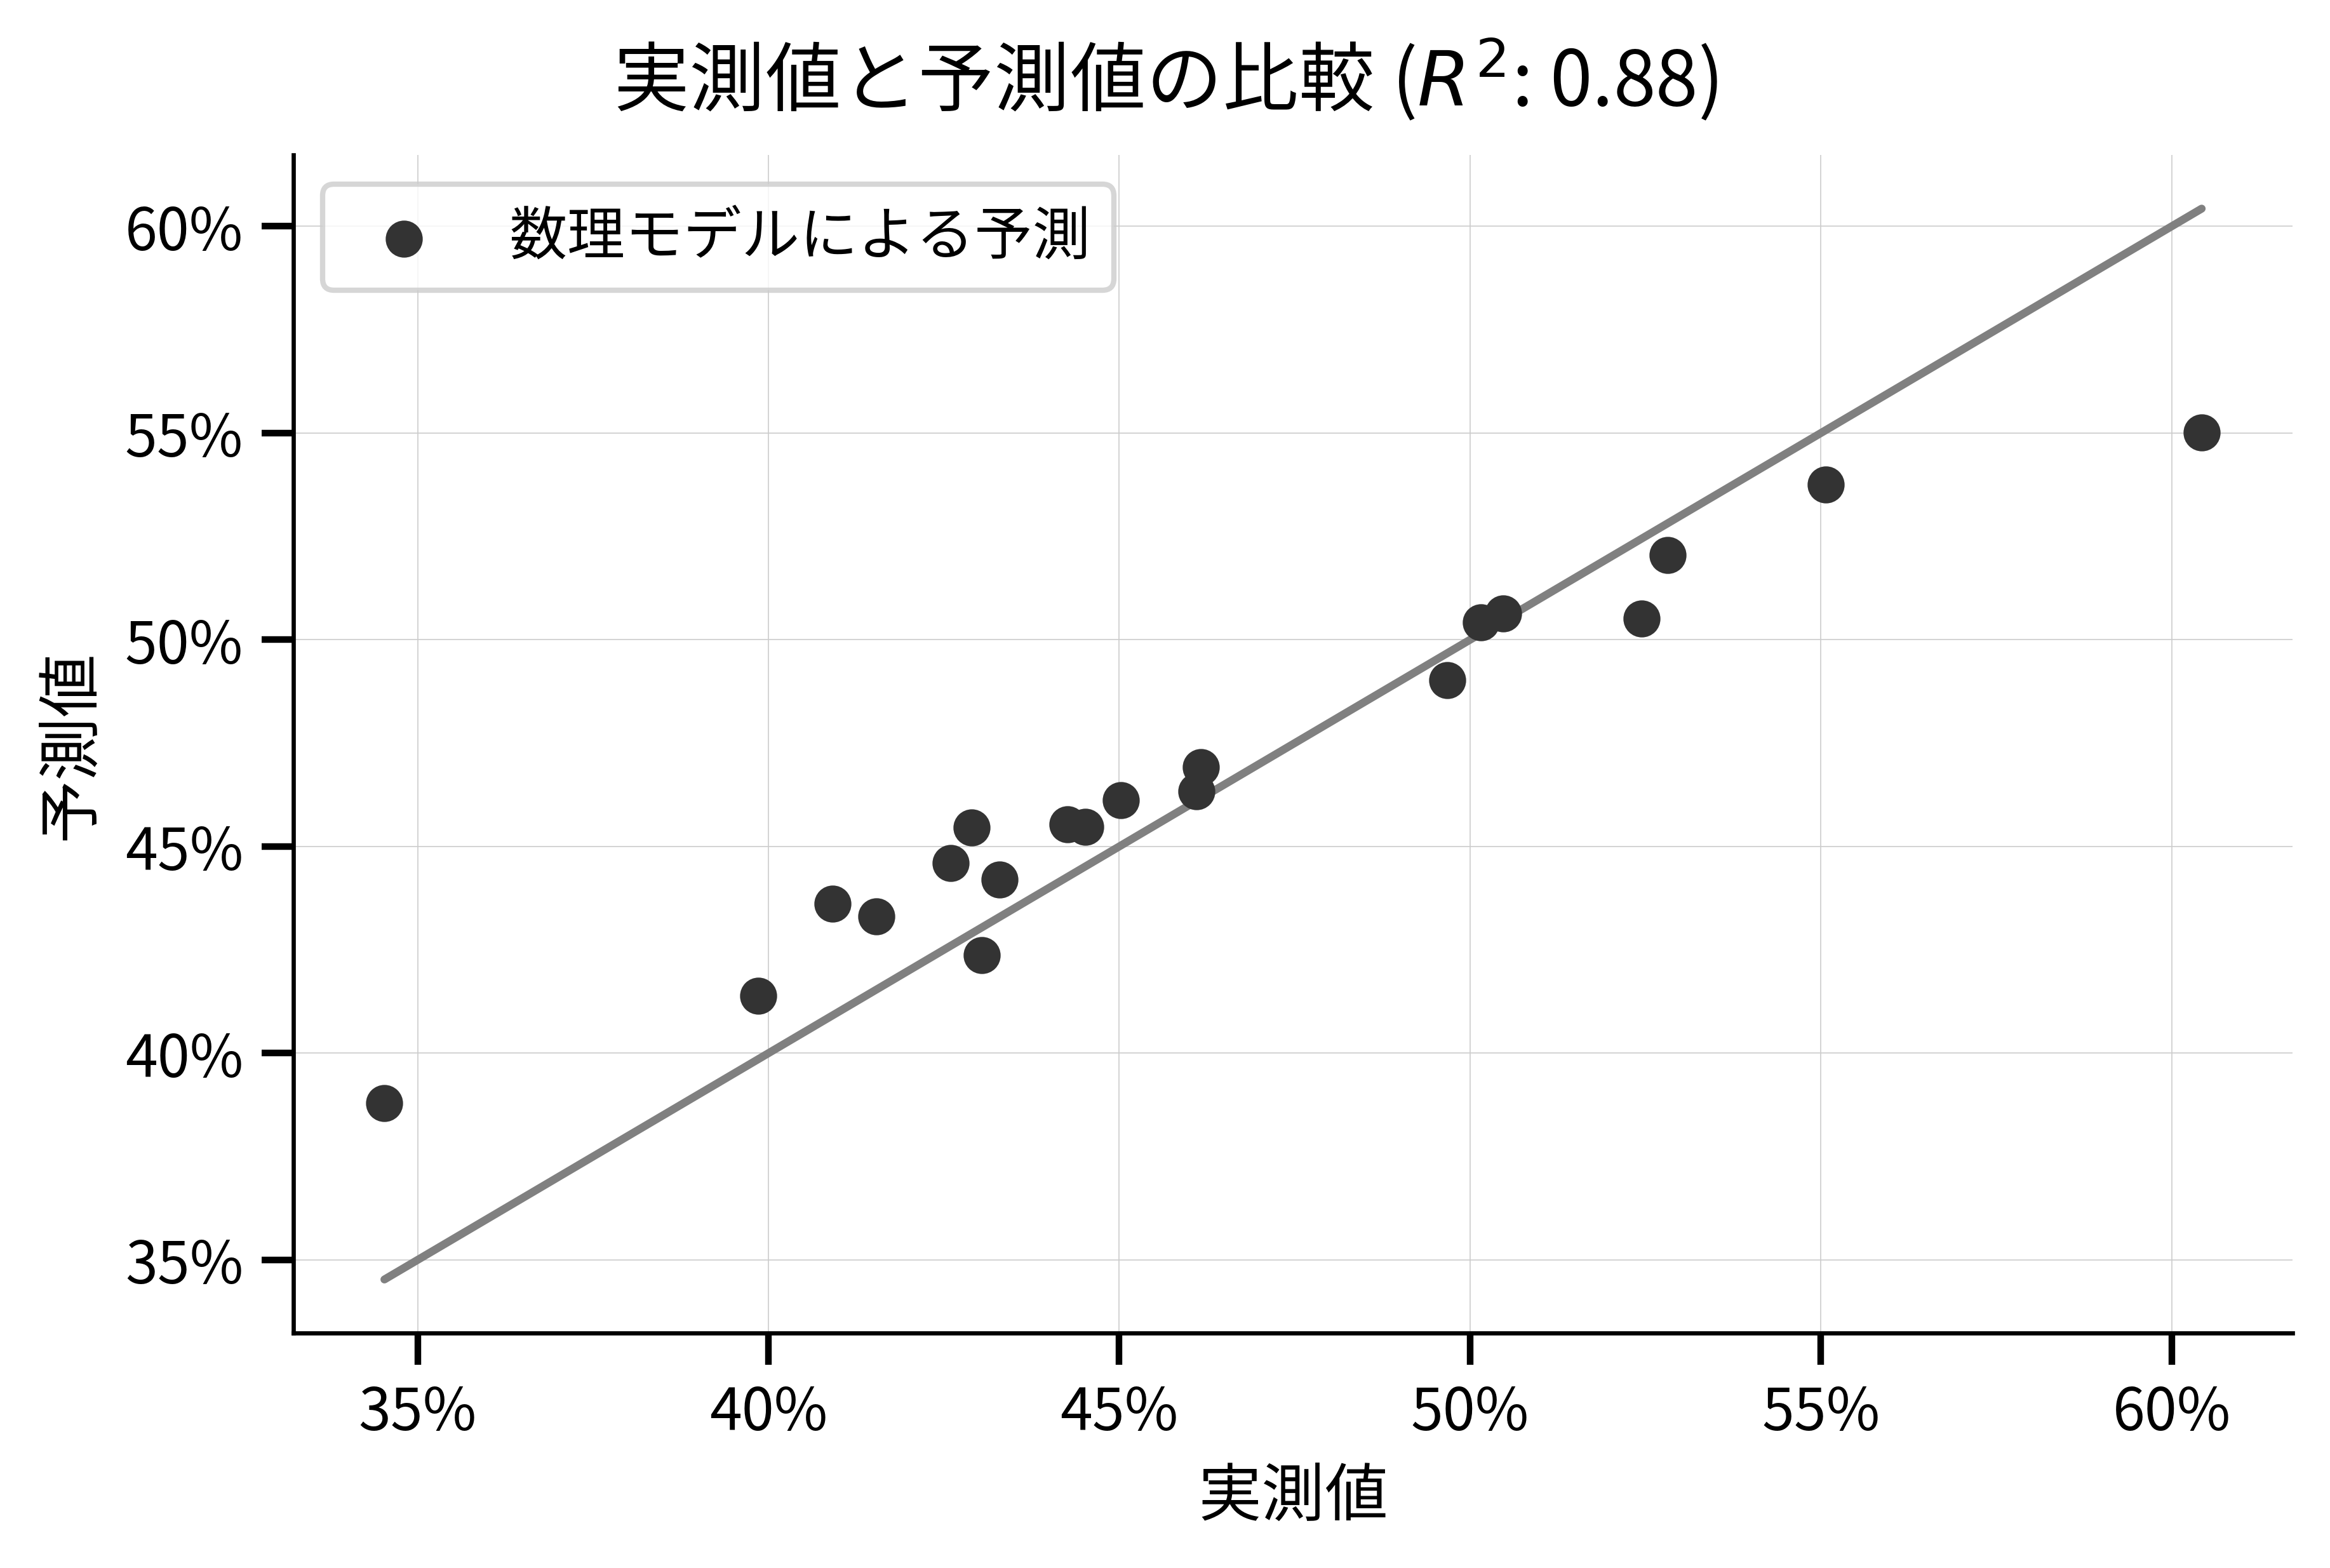

In [21]:
# 予測精度の可視化
fig, ax = plot_compare_actual_prediction(
    y_true=r,
    y_pred=r_pred_tsre,
    prediction_label="数理モデルによる予測",
    title="実測値と予測値の比較",
)

## ステップ3：数理最適化問題を解いて 最適なアクションを導出する

In [22]:
def optimize(
    estimator: TwoStageReachEstimator,
    b: float,
    c: np.ndarray,
) -> tuple[float, np.ndarray, np.ndarray]:
    """合算のユニークリーチを最大化する予算配分を計算"""

    # 媒体数
    m = c.shape[0]

    result = minimize(
        fun=lambda g: -estimator.predict(g.reshape(1, -1)),  # 最小化なので-1をかける
        x0=np.zeros(m),  # 初期値。なんでもいい
        bounds=[(0, None)] * m,  # グロスリーチは0以上
        constraints=[
            {
                "type": "ineq",
                "fun": lambda g: b - 100 * c @ g,
            }
        ],  # 予算制約
        tol=1e-10,
    )

    g_opt = result.x  # 最適なグロスリーチの配分
    s_opt = 100 * c * g_opt / b  # 最適な予算シェア
    r_opt = -result.fun  # 最大化された合算のユニークリーチ

    print(f"最適なグロスリーチ: {g_opt.round(3)}")
    print(f"最適な予算配分（金額）: {(b * s_opt).round(0)}")
    print(f"最適な予算配分（割合） {s_opt.round(3)}")
    print(f"獲得できる合算のユニークリーチ: {r_opt:.3f}")

    return r_opt, g_opt, s_opt


b = 3000  # 予算上限（万円単位）
c = np.array([10, 10])  # グロスリーチ1%あたりのコスト（万円単位）

# 全データで学習
tsre = TwoStageReachEstimator().fit(G, R, r)

# 最適配分を計算
r_opt, g_opt, s_opt = optimize(estimator=tsre, b=b, c=c)

最適なグロスリーチ: [2.13 0.87]
最適な予算配分（金額）: [2130.  870.]
最適な予算配分（割合） [0.71 0.29]
獲得できる合算のユニークリーチ: 0.548


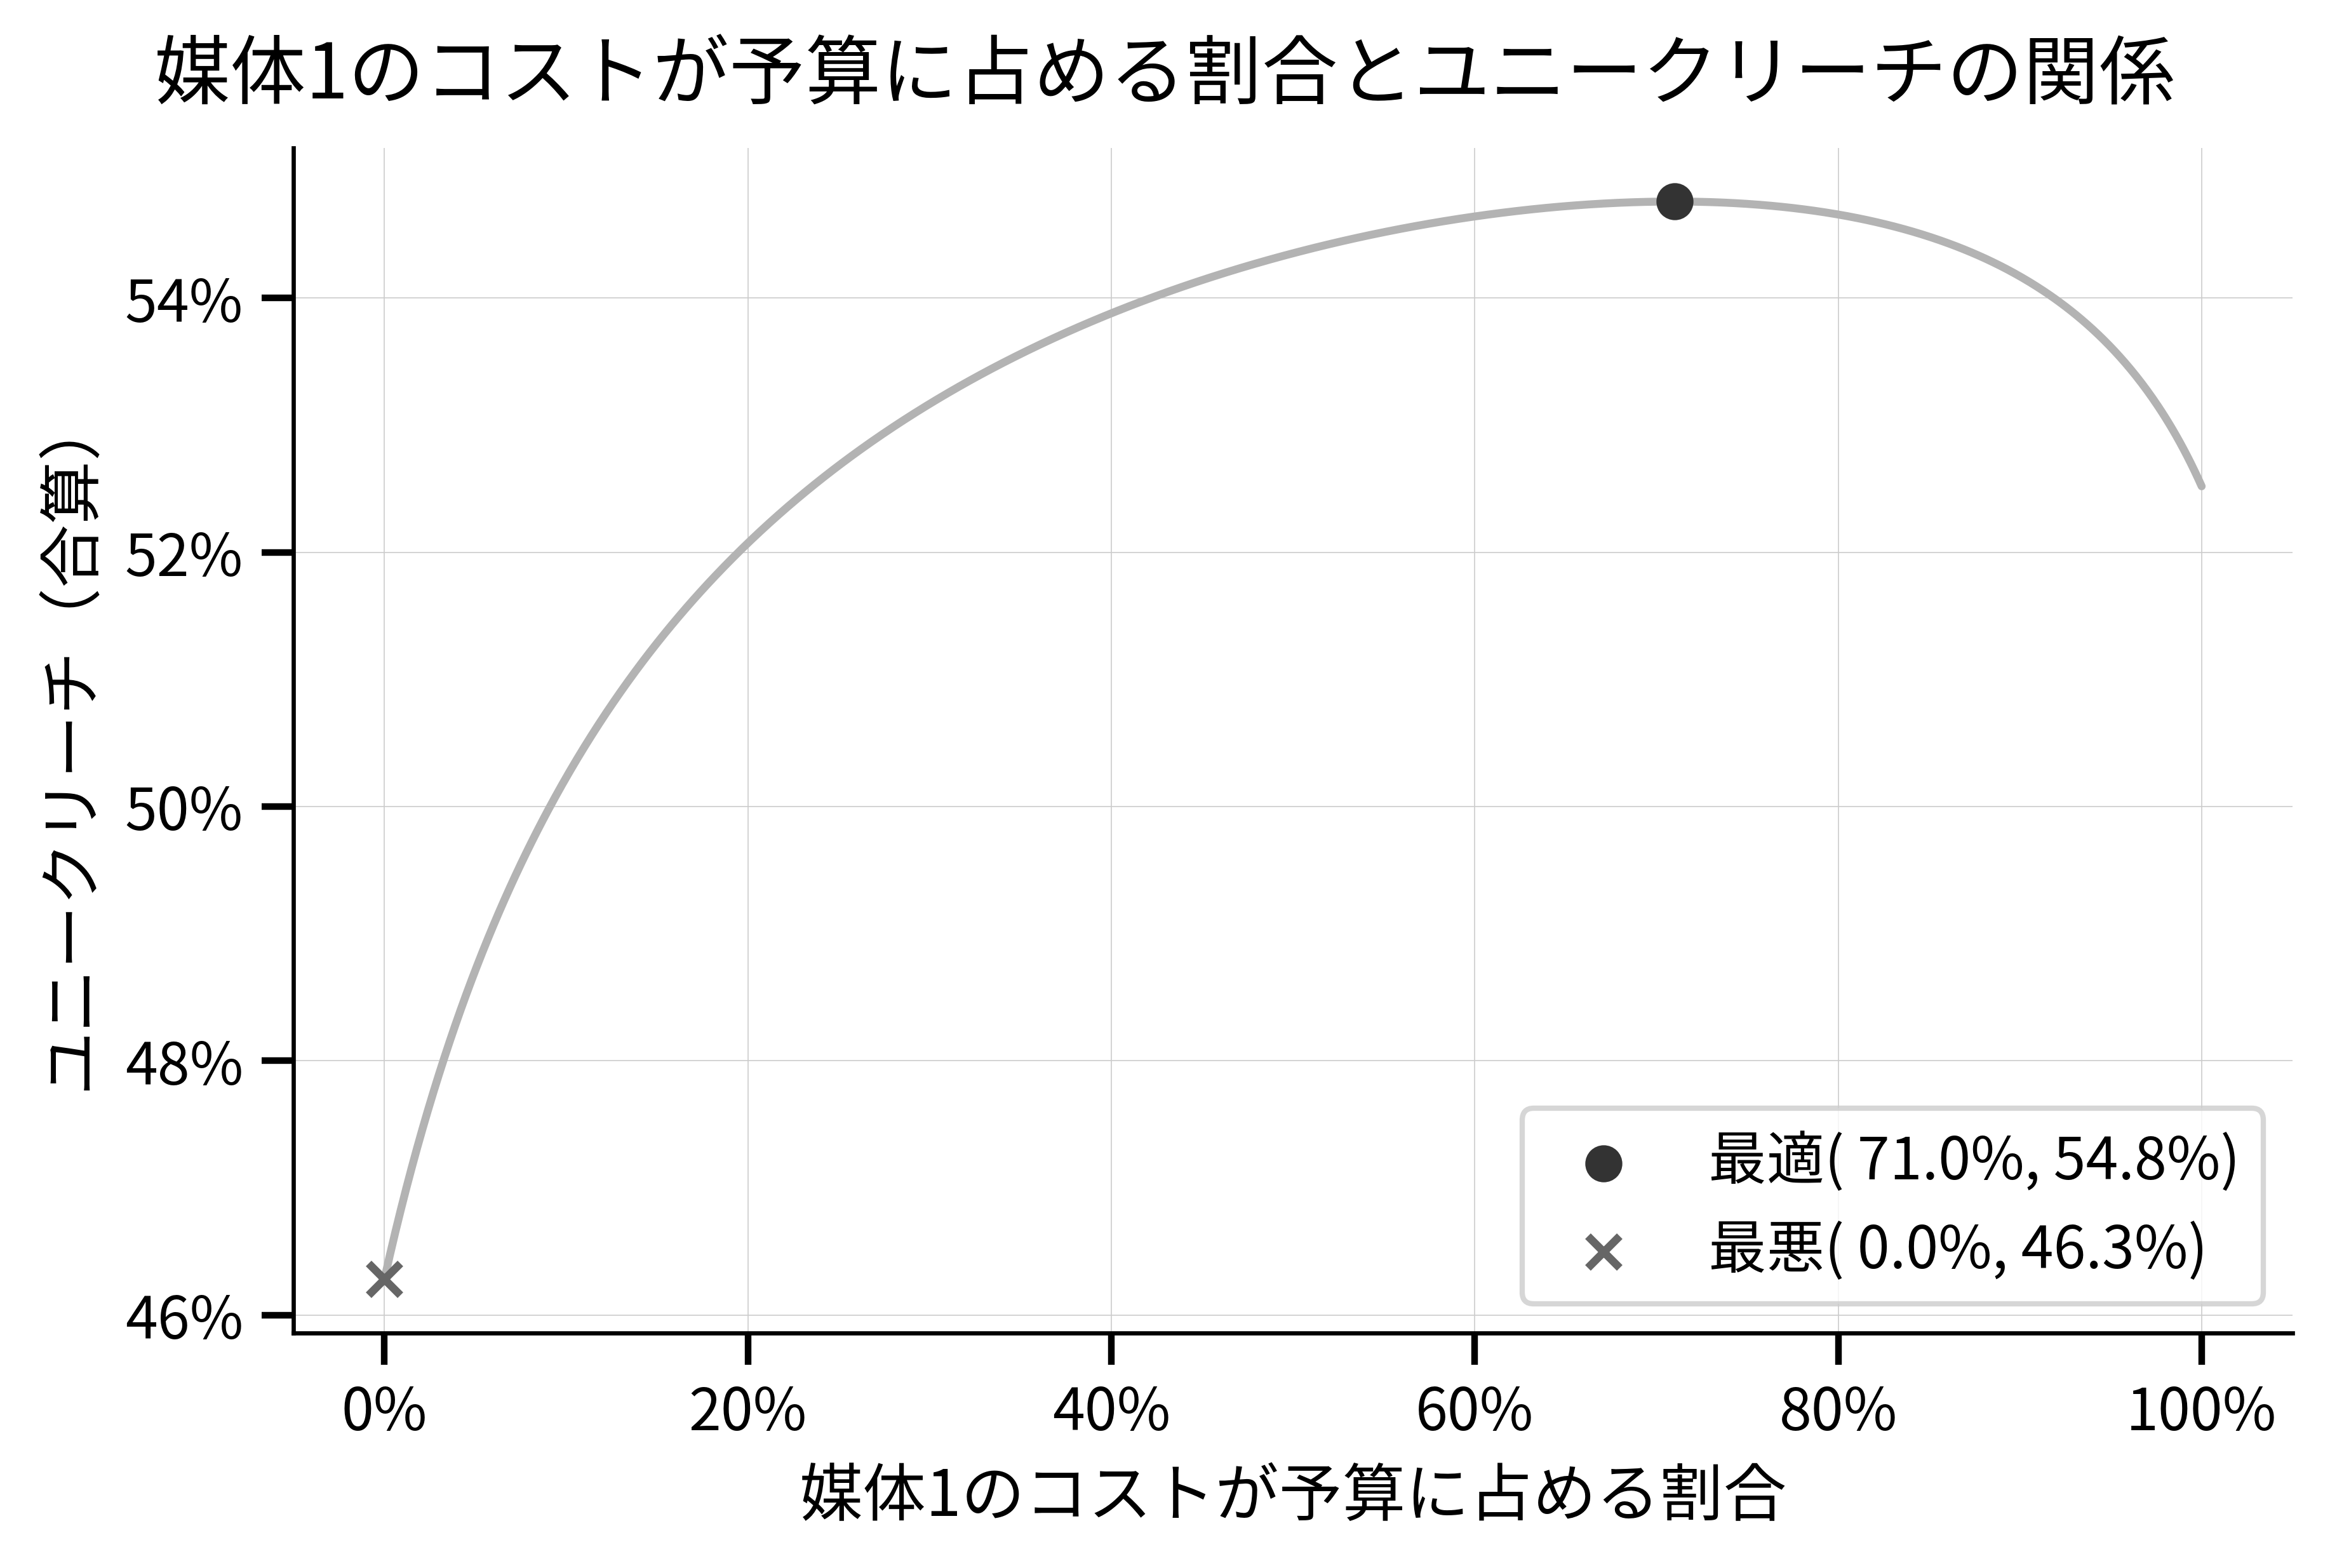

In [23]:
def plot_optimal_share(
    estimator: TwoStageReachEstimator,
    b: int | float,
    c: np.ndarray,
) -> tuple[Figure, Axes]:
    """最適な予算配分を計算"""

    # 予算に占める媒体1のコストの割合
    s = np.linspace(0, 1, num=1001)
    # 予算配分から計算した各媒体のグロスリーチ
    g = b * np.array([s, 1 - s]) / (100 * c[:, None])

    # 予測モデルでユニークリーチを予測
    r_pred = estimator.predict(g.T)

    max_index = np.argmax(r_pred)  # ユニークリーチを最大化するインデックス
    optimal_s, optimal_r = (
        s[max_index],
        r_pred[max_index],
    )  # その時の予算配分とユニークリーチ

    min_index = np.argmin(r_pred)  # ユニークリーチを最小化するインデックス
    worst_s, worst_r = (
        s[min_index],
        r_pred[min_index],
    )  # その時の予算配分とユニークリーチ

    fig, ax = plt.subplots()
    ax.plot(s, r_pred, c=".7", zorder=1)
    ax.scatter(
        optimal_s,
        optimal_r,
        marker="o",
        label=f"最適({optimal_s * 100: .1f}%, {optimal_r * 100:.1f}%)",
        zorder=2,
    )
    ax.scatter(
        worst_s,
        worst_r,
        marker="x",
        label=f"最悪({worst_s * 100: .1f}%, {worst_r * 100:.1f}%)",
        zorder=3,
    )
    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(
        xlabel="媒体1のコストが予算に占める割合",
        ylabel="ユニークリーチ（合算）",
    )
    fig.suptitle("媒体1のコストが予算に占める割合とユニークリーチの関係")

    return fig, ax


# 各配分におけるユニークリーチの予測値を可視化
fig, ax = plot_optimal_share(estimator=tsre, b=b, c=c)

In [24]:
def validate_prediction(
    estimator: TwoStageReachEstimator,
    b: int | float,
    c: np.ndarray,
) -> np.bool_:
    """最適化で用いた設定に対して、
    重複リーチが各媒体のユニークリーチを超えないか確認
    """

    # 予算に占める媒体1のコストの割合
    s = np.linspace(0, 1, num=101)
    # 予算配分から計算した各媒体のグロスリーチ
    g = b * np.array([s, 1 - s]) / (100 * c.reshape(-1, 1))

    # 予測モデルでユニークリーチを予測
    # 媒体ごとのユニークリーチと、重複部分のユニークリーチを予測
    R_pred_individual = estimator.predict_individual_reach(g.T)

    # 各媒体のユニークリーチから重複リーチを引く
    diff = R_pred_individual - R_pred_individual[:, [2]]

    # 0未満になっていると重複リーチの方が大きい
    # すべての予算配分で、0以上になっていることを確かめる
    return np.all(diff >= 0)


validate_prediction(estimator=tsre, b=b, c=c)

True

## まとめ
